# Physik der sozio-ökonomischen Systeme mit dem Computer
# (Physics of Socio-Economic Systems with the Computer)

### Vorlesung gehalten an der J.W.Goethe-Universität in Frankfurt am Main 
#### (Wintersemester 2020/21)

### von Dr.phil.nat. Dr.rer.pol. Matthias Hanauske

### Frankfurt am Main 31.12.2020


### Zweiter Vorlesungsteil:  
### Ausbreitung eines Virus auf einem komplexen Netzwerk
#### Simulationsbasierte Lösungen


## Einführung

Eine bedeutende Einschränkung des deterministischen SIR-Modells der Virusausbreitung ist die im Modell angenommene vereinfachte Kontakt-Netzwerkstruktur der das Virus verbreitenden Personen. Die Ausbreitung eines Krankheitserregers (z.B. Covid-19 Virus), eines Computervirus im Internet oder eines Gerüchts ("Fake-News") in einem sozialen Netzwerk hängt jedoch stark von der Topologie des zugrundeliegenden komplexen Netzwerkes ab. 

Die wegweisende, im Jahre 2001 veröffentlichte Arbeit von Romualdo Pastor-Satorras und Alessandro Vespignani (siehe <A href="https://arxiv.org/pdf/cond-mat/0010317.pdf" target=blank>R. Pastor-Satorras and A. Vespignani. Epidemic spreading in scalefree networks. Physical Review Letters, 86:3200–3203, 2001.</A>) betrachtete z.B. die epidemische Ausbreitung eines Krankheitserregers auf einem skalenfreien Netzwerk. 

Im Folgenden werden wir die epidemische Ausbreitung auf unterschiedlichen Kontakt-Netzwerken mittels eines simulationsbasierten Ansatzes untersuchen. 

Unser erstes Beispiel betrachtet zunächst die Ausbreitung eines Krankheitserregers auf einem räumlichen 2-dimensionalen Gitter, wobei jede Person mit seinen nächsten Nachbarn verbunden ist. Wir erzeugen zunächst das räumliche Netzwerk der Personen und stellen dies dar. Im Anfangsnetzwerk, zur Zeit t=0 nehmen wir an, dass alle Personen außer einer noch nicht mit dem Virus in Kontakt getreten sind. Die infizierte Person (rotes Viereck) platzieren wir nahe der Mitte des räumlichen Gitters und alle anderen Personen kennzeichnen wir durch blaue Vierecke. Wir betrachten zunächst ein Netzwerk aus $N=35 \cdot 35=1225$ Individuen.

In [1]:
import networkx as nx
from random import randint
import numpy as np

G=nx.Graph()
Nx=35
Ny=35
N=int(Nx*Ny)
PropPlayers=np.zeros([N,10])

In [2]:
k=0
ColorPlayer=[]
for i in range(0,Nx):
    for j in range(0,Ny):
        G.add_node(k)
        PropPlayers[k].flat[0] = k #Knotennummer
        PropPlayers[k].flat[1] = i #x-Koordinate auf dem 2-D Gitter
        PropPlayers[k].flat[2] = j #y-Koordinate auf dem 2-D Gitter 
        if k==int(N/2):
            strategy=1 #entspricht I: Ansteckende Person
            ColorPlayer.append("red")
        else:
            strategy=0 #entspricht S: Gesunde Person
            ColorPlayer.append("blue")
        PropPlayers[k].flat[3] = strategy 
        
        center = i*Ny + j
        upperleft = ((i-1)%Nx)*Ny + (j-1)%Ny
        up = ((i  )%Nx)*Ny + (j-1)%Ny
        upperright = ((i+1)%Nx)*Ny + (j-1)%Ny
        right = ((i+1)%Nx)*Ny + (j  )%Ny
        lowerright = ((i+1)%Nx)*Ny + (j+1)%Ny
        low = ((i  )%Nx)*Ny + (j+1)%Ny
        lowerleft = ((i-1)%Nx)*Ny + (j+1)%Ny
        left = ((i-1)%Nx)*Ny + (j  )%Ny
        G.add_edge(center, upperleft)
        G.add_edge(center, up)
        G.add_edge(center, upperright)
        G.add_edge(center, right)
        G.add_edge(center, lowerright)
        G.add_edge(center, low)
        G.add_edge(center, lowerleft)
        G.add_edge(center, left)
        k=k+1

Die Verlinkungswahrscheinlichkeit p und der durchschnittliche Knotengrad $\bar{k}=<\! k \!>$ des erzeugten Netzwerks haben die folgenden Werte (jede Person besitzt 8 nächste Nachbarn):

In [3]:
p=(2*G.number_of_edges()/(N*(N-1)))
print("Verlinkungswahrscheinlichkeit p:")
print(p)
sumki=0
for i in G.nodes():
    sumki=sumki+G.degree()[i]
avki=sumki/N
print("Durchschnittliche Knotengrad:")
print(avki)

Verlinkungswahrscheinlichkeit p:
0.006535947712418301
Durchschnittliche Knotengrad:
8.0


In [7]:
import matplotlib.pyplot as plt 
import matplotlib
import matplotlib.animation as animation
from IPython.display import HTML
params = {
    'figure.figsize'    : [4.5,4.5],
#    'text.usetex'       : True,
    'axes.titlesize' : 14,
    'axes.labelsize' : 16,  
    'xtick.labelsize' : 14 ,
    'ytick.labelsize' : 14 
}
matplotlib.rcParams.update(params) 

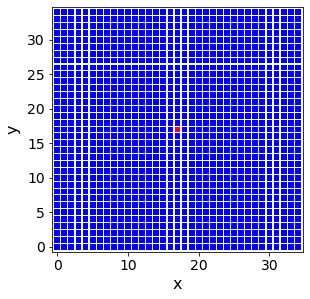

In [8]:
fig = plt.figure()
ax = fig.gca()
ax.scatter(PropPlayers[:,1],PropPlayers[:,2],s=34,c=ColorPlayer,marker="s",alpha=1,edgecolor='none')
ax.set_xlim(-0.75, Nx-0.25)
ax.set_ylim(-0.75, Ny-0.25)
ax.set_ylabel(r"$\rm y$")
ax.set_xlabel(r"$\rm x$");

Wir implementieren nun die zeitliche Entwicklung der Virusausbreitung. Wir nehmen an, dass in jeder Zeiteinheit $\Delta t$ jede Person mit seinen acht direkten Nachbarn in Kontakt tritt und dass die Wahrscheinlichkeit, dass die Krankheit von einem Infizierten auf die andere Person übertragen wird, mittels des Parameters $\beta$ quantifiziert ist. Zusätzlich können sich infizierte Personen mit einer Wahrscheinlichkeit $\mu$ von der Krankheit erholen/sterben. Die genesenen ("Recovered") Personen betrachten wir zunächst als nicht mehr infizierbar (immun) und nehmen zusätzlich an, dass sie auch keine Anderen infizieren können. Wir fügen dieser Personengruppe auch die Personen hinzu, die an dem Virus gestorben sind (Removed). Die Wahrscheinlichkeit $\mu$ der in der Zeiteinheit $\Delta t$ aus dem System herausgenommenen Personen ergibt sich somit zu $\mu=\mu_{Reco}+\mu_{Dead}$.

Wir definieren zunächst eine Kontakt-Funktion, die die mit $\beta$ gewichtete Übertragung des Virus formalisiert. Zusätzlich definieren wir eine Funktion, die die Genesung und den möglichen Tot mittels der Wahrscheinlichkeit $\mu=\mu_{\rm Reco}+\mu_{\rm Dead}$ beschreibt.

In [9]:
beta,mu,sterberate=0.2,0.1,0.01
def MakeKontakt():
    VirusSpread=0
    strategy=randint(0, 100000)
    if strategy<=100000*beta:
        VirusSpread=1
    return VirusSpread
def GenesTot():
    state=1
    strategy=randint(0, 100000)
    strategy1=randint(0, 100000)
    if strategy<=100000*mu:
        state=2
        if strategy1<=100000*sterberate:
            state=3
    return state

In [10]:
print("R0=",beta*8/mu)

R0= 16.0


In der folgenden Animation stellen wir den epidemischen Verlauf der Virusausbreitung auf dem räumlichen Gitter dar, wobei wir die Parameter des Modells wie folgt festlegen: $\beta=0.2,\mu=0.1 \rightarrow R_0=\frac{\beta \, <\! k \!>}{\mu}=16$. Weiter nehmen wir an, dass 1% (Sterberate: 0.01) der in der Zeiteinheit $\Delta t$ aus dem System herausgenommenen Personen an dem Virus sterben und 99% genesen ($\mu_{\rm Dead}=0.001$). Die einzelnen Kästchen in der Animation entsprechen den Personen der Population und die Farbzuweisung kennzeichnet den Zustand der Person: 
Noch nicht erkrankten Personen S (blau), infizierten Personen I (rot), R genesenen (grün) und gestorbenen (schwarz) Personen.

In [11]:
beta,mu,sterberate=0.2,0.1,0.01
G=nx.Graph()
Nx=35
Ny=35
N=int(Nx*Ny)
PropPlayers=np.zeros([N,10])
Nframes=100
SIR=np.zeros([Nframes,4])

fig = plt.figure()
ax = fig.gca()

def init():
    k=0
    ColorPlayer=[]
    for i in range(0,Nx):
        for j in range(0,Ny):
            G.add_node(k)
            PropPlayers[k].flat[0] = k #Knotennummer
            PropPlayers[k].flat[1] = i #x-Koordinate auf dem 2-D Gitter
            PropPlayers[k].flat[2] = j #y-Koordinate auf dem 2-D Gitter 
            if k==int(N/2):
                strategy=1 #entspricht I: Ansteckende Person
                ColorPlayer.append("red")
            else:
                strategy=0 #entspricht S: Gesunde Person
                ColorPlayer.append("blue")
            PropPlayers[k].flat[3] = strategy 
        
            center = i*Ny + j
            upperleft = ((i-1)%Nx)*Ny + (j-1)%Ny
            up = ((i  )%Nx)*Ny + (j-1)%Ny
            upperright = ((i+1)%Nx)*Ny + (j-1)%Ny
            right = ((i+1)%Nx)*Ny + (j  )%Ny
            lowerright = ((i+1)%Nx)*Ny + (j+1)%Ny
            low = ((i  )%Nx)*Ny + (j+1)%Ny
            lowerleft = ((i-1)%Nx)*Ny + (j+1)%Ny
            left = ((i-1)%Nx)*Ny + (j  )%Ny
            G.add_edge(center, upperleft)
            G.add_edge(center, up)
            G.add_edge(center, upperright)
            G.add_edge(center, right)
            G.add_edge(center, lowerright)
            G.add_edge(center, low)
            G.add_edge(center, lowerleft)
            G.add_edge(center, left)
            k=k+1
    return fig,

def animate(i):
    ax.cla()
    for n in range(0,N):
        PropPlayers[n,4] == PropPlayers[n,3]
    for games in list(G.edges):
        if PropPlayers[games[0],3] == 1 and PropPlayers[games[1],3] == 0:
            PropPlayers[games[1]].flat[4]=MakeKontakt()
        if PropPlayers[games[1],3] == 1 and PropPlayers[games[0],3] == 0:
            PropPlayers[games[0]].flat[4]=MakeKontakt()   
    ColorPlayernew=[]
    ColorPlayer=[]
    for n in range(0,N):
        if PropPlayers[n,3] == 1:
            PropPlayers[n].flat[4]=GenesTot()
        if PropPlayers[n,4]==0:
            ColorPlayernew.append("blue")
        if PropPlayers[n,4]==1:
            ColorPlayernew.append("red")
        if PropPlayers[n,4]==2:
            ColorPlayernew.append("green")
        if PropPlayers[n,4]==3:
            ColorPlayernew.append("black")
        if PropPlayers[n,3]==0:
            SIR[i,0]=SIR[i,0]+1
            ColorPlayer.append("blue")
        if PropPlayers[n,3]==1:
            SIR[i,1]=SIR[i,1]+1
            ColorPlayer.append("red")
        if PropPlayers[n,3]==2:
            SIR[i,2]=SIR[i,2]+1
            ColorPlayer.append("green") 
        if PropPlayers[n,3]==3:
            SIR[i,3]=SIR[i,3]+1
            ColorPlayer.append("black") 
        PropPlayers[n].flat[3] = PropPlayers[n,4]
    ax.scatter(PropPlayers[:,1],PropPlayers[:,2],s=34,c=ColorPlayer,marker="s",alpha=1,edgecolor='none')
    ax.set_xlim(-0.75, Nx-0.25)
    ax.set_ylim(-0.75, Ny-0.25)
    ax.set_ylabel(r"$\rm y$")
    ax.set_xlabel(r"$\rm x$")
    ColorPlayer=ColorPlayernew
    return fig,

ani = animation.FuncAnimation(fig,animate,init_func=init,frames=Nframes,interval=400)

plt.close(ani._fig)

HTML(ani.to_html5_video())

Wir stellen uns die zeitliche Entwicklung der Virusausbreitung durch die Anteile der noch nicht erkrankten Personen $s(t)=\frac{S(t)}{N}$, den Anteil der infizierten Personen $i(t)=\frac{I(t)}{N}$ und den Anteil der genesenen und gestorbenen Personen $r(t)=\frac{R(t)}{N}$ dar.

In [12]:
params = {
    'figure.figsize'    : [8,5],
    'text.usetex'       : True,
    'axes.titlesize' : 14,
    'axes.labelsize' : 16,  
    'xtick.labelsize' : 14 ,
    'ytick.labelsize' : 14 
}
matplotlib.rcParams.update(params) 

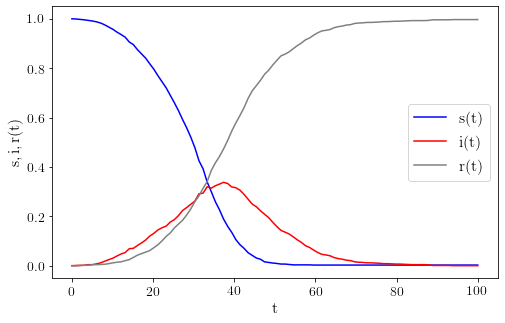

In [13]:
tval = np.linspace(0, Nframes, Nframes)
plt.xlabel(r"$\rm t$")
plt.ylabel(r"$\rm s,i,r(t)$")
plt.plot(tval, SIR[:,0]/N,c="blue", label=r"$\rm s(t)$");
plt.plot(tval, SIR[:,1]/N,c="red", label=r"$\rm i(t)$");
plt.plot(tval, (SIR[:,2]+SIR[:,3])/N,c="grey", label=r"$\rm r(t)$");
plt.legend(loc='center right',fontsize=16);

Der oben dargestellte Simulationsverlauf der epidemischen Ausbreitung stimmt qualitativ mit den Vorhersagen des analytischen SIR-Modells überein. Der Anstieg der infizierten Personen (rote Kurve) steigt jedoch weniger stark an und sein maximaler Wert ist kleiner und wird zu einem späteren Zeitpunkt erreicht als beim analytischen SIR-Modell. Wir stellen die räumliche Animation und den zeitlichen Verlauf der SIR-Anteile nochmals nebeneinander dar:

In [14]:
import matplotlib.gridspec as gridspec
params = {
    'figure.figsize'    : [10,4.5],
    'text.usetex'       : True,
    'axes.titlesize' : 14,
    'axes.labelsize' : 16,  
    'xtick.labelsize' : 14 ,
    'ytick.labelsize' : 14 
}
matplotlib.rcParams.update(params) 

In [15]:
beta,mu,sterberate=0.2,0.1,0.01
G=nx.Graph()
Nx=35
Ny=35
N=int(Nx*Ny)
PropPlayers=np.zeros([N,10])
Nframes=100
SIR=np.zeros([Nframes,4])

tval = np.linspace(0, Nframes, Nframes)

fig = plt.figure()
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1], wspace=0.3)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

def init():
    k=0
    ColorPlayer=[]
    for i in range(0,Nx):
        for j in range(0,Ny):
            G.add_node(k)
            PropPlayers[k].flat[0] = k #Knotennummer
            PropPlayers[k].flat[1] = i #x-Koordinate auf dem 2-D Gitter
            PropPlayers[k].flat[2] = j #y-Koordinate auf dem 2-D Gitter 
            if k==int(N/2):
                strategy=1 #entspricht I: Ansteckende Person
                ColorPlayer.append("red")
            else:
                strategy=0 #entspricht S: Gesunde Person
                ColorPlayer.append("blue")
            PropPlayers[k].flat[3] = strategy 
        
            center = i*Ny + j
            upperleft = ((i-1)%Nx)*Ny + (j-1)%Ny
            up = ((i  )%Nx)*Ny + (j-1)%Ny
            upperright = ((i+1)%Nx)*Ny + (j-1)%Ny
            right = ((i+1)%Nx)*Ny + (j  )%Ny
            lowerright = ((i+1)%Nx)*Ny + (j+1)%Ny
            low = ((i  )%Nx)*Ny + (j+1)%Ny
            lowerleft = ((i-1)%Nx)*Ny + (j+1)%Ny
            left = ((i-1)%Nx)*Ny + (j  )%Ny
            G.add_edge(center, upperleft)
            G.add_edge(center, up)
            G.add_edge(center, upperright)
            G.add_edge(center, right)
            G.add_edge(center, lowerright)
            G.add_edge(center, low)
            G.add_edge(center, lowerleft)
            G.add_edge(center, left)
            k=k+1
    return fig,

def animate(i):
    ax1.cla()
    ax2.cla()
    for n in range(0,N):
        PropPlayers[n,4] == PropPlayers[n,3]
    for games in list(G.edges):
        if PropPlayers[games[0],3] == 1 and PropPlayers[games[1],3] == 0:
            PropPlayers[games[1]].flat[4]=MakeKontakt()
        if PropPlayers[games[1],3] == 1 and PropPlayers[games[0],3] == 0:
            PropPlayers[games[0]].flat[4]=MakeKontakt()   
    ColorPlayernew=[]
    ColorPlayer=[]
    for n in range(0,N):
        if PropPlayers[n,3] == 1:
            PropPlayers[n].flat[4]=GenesTot()
        if PropPlayers[n,4]==0:
            ColorPlayernew.append("blue")
        if PropPlayers[n,4]==1:
            ColorPlayernew.append("red")
        if PropPlayers[n,4]==2:
            ColorPlayernew.append("green")
        if PropPlayers[n,4]==3:
            ColorPlayernew.append("black")
        if PropPlayers[n,3]==0:
            SIR[i,0]=SIR[i,0]+1
            ColorPlayer.append("blue")
        if PropPlayers[n,3]==1:
            SIR[i,1]=SIR[i,1]+1
            ColorPlayer.append("red")
        if PropPlayers[n,3]==2:
            SIR[i,2]=SIR[i,2]+1
            ColorPlayer.append("green") 
        if PropPlayers[n,3]==3:
            SIR[i,3]=SIR[i,3]+1
            ColorPlayer.append("black") 
        PropPlayers[n].flat[3] = PropPlayers[n,4]
    ax2.scatter(PropPlayers[:,1],PropPlayers[:,2],s=34,c=ColorPlayer,marker="s",alpha=1,edgecolor='none')
    ax2.set_xlim(-0.75, Nx-0.25)
    ax2.set_ylim(-0.75, Ny-0.25)
    ax2.set_ylabel(r"$\rm y$")
    ax2.set_xlabel(r"$\rm x$")
    ColorPlayer=ColorPlayernew
    
    ax1.plot(tval[:i], SIR[:i,0]/N,c="blue", label=r"$\rm s(t)$");
    ax1.plot(tval[:i], SIR[:i,1]/N,c="red", label=r"$\rm i(t)$");
    ax1.plot(tval[:i], (SIR[:i,2]+SIR[:i,3])/N,c="grey", label=r"$\rm r(t)$");
    ax1.set_xlabel(r"$\rm t$")
    ax1.set_ylabel(r"$\rm s,i,r(t)$")
    ax1.set_xlim(0, Nframes)
    ax1.set_ylim(0, 1)
    return fig,

ani = animation.FuncAnimation(fig,animate,init_func=init,frames=Nframes,interval=400)

plt.close(ani._fig)

HTML(ani.to_html5_video())

Wir betrachten nun die Auswirkung der Größe des räumlichen Netzwerks der Personen und gehen von einem räumlichen Gitter bestehend aus $N=35 \cdot 35=1225$ Individuen zu einem Netzwerk bestehend aus $N=65 \cdot 65=4225$ Personen über.

In [16]:
beta,mu,sterberate=0.2,0.1,0.01
G=nx.Graph()
Nx=65
Ny=65
N=int(Nx*Ny)
PropPlayers=np.zeros([N,10])
Nframes=100
SIR=np.zeros([Nframes,4])

tval = np.linspace(0, Nframes, Nframes)

fig = plt.figure()
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1], wspace=0.3)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

def init():
    k=0
    ColorPlayer=[]
    for i in range(0,Nx):
        for j in range(0,Ny):
            G.add_node(k)
            PropPlayers[k].flat[0] = k #Knotennummer
            PropPlayers[k].flat[1] = i #x-Koordinate auf dem 2-D Gitter
            PropPlayers[k].flat[2] = j #y-Koordinate auf dem 2-D Gitter 
            if k==int(N/2):
                strategy=1 #entspricht I: Ansteckende Person
                ColorPlayer.append("red")
            else:
                strategy=0 #entspricht S: Gesunde Person
                ColorPlayer.append("blue")
            PropPlayers[k].flat[3] = strategy 
        
            center = i*Ny + j
            upperleft = ((i-1)%Nx)*Ny + (j-1)%Ny
            up = ((i  )%Nx)*Ny + (j-1)%Ny
            upperright = ((i+1)%Nx)*Ny + (j-1)%Ny
            right = ((i+1)%Nx)*Ny + (j  )%Ny
            lowerright = ((i+1)%Nx)*Ny + (j+1)%Ny
            low = ((i  )%Nx)*Ny + (j+1)%Ny
            lowerleft = ((i-1)%Nx)*Ny + (j+1)%Ny
            left = ((i-1)%Nx)*Ny + (j  )%Ny
            G.add_edge(center, upperleft)
            G.add_edge(center, up)
            G.add_edge(center, upperright)
            G.add_edge(center, right)
            G.add_edge(center, lowerright)
            G.add_edge(center, low)
            G.add_edge(center, lowerleft)
            G.add_edge(center, left)
            k=k+1
    return fig,

def animate(i):
    ax1.cla()
    ax2.cla()
    for n in range(0,N):
        PropPlayers[n,4] == PropPlayers[n,3]
    for games in list(G.edges):
        if PropPlayers[games[0],3] == 1 and PropPlayers[games[1],3] == 0:
            PropPlayers[games[1]].flat[4]=MakeKontakt()
        if PropPlayers[games[1],3] == 1 and PropPlayers[games[0],3] == 0:
            PropPlayers[games[0]].flat[4]=MakeKontakt()   
    ColorPlayernew=[]
    ColorPlayer=[]
    for n in range(0,N):
        if PropPlayers[n,3] == 1:
            PropPlayers[n].flat[4]=GenesTot()
        if PropPlayers[n,4]==0:
            ColorPlayernew.append("blue")
        if PropPlayers[n,4]==1:
            ColorPlayernew.append("red")
        if PropPlayers[n,4]==2:
            ColorPlayernew.append("green")
        if PropPlayers[n,4]==3:
            ColorPlayernew.append("black")
        if PropPlayers[n,3]==0:
            SIR[i,0]=SIR[i,0]+1
            ColorPlayer.append("blue")
        if PropPlayers[n,3]==1:
            SIR[i,1]=SIR[i,1]+1
            ColorPlayer.append("red")
        if PropPlayers[n,3]==2:
            SIR[i,2]=SIR[i,2]+1
            ColorPlayer.append("green") 
        if PropPlayers[n,3]==3:
            SIR[i,3]=SIR[i,3]+1
            ColorPlayer.append("black") 
        PropPlayers[n].flat[3] = PropPlayers[n,4]
    ax2.scatter(PropPlayers[:,1],PropPlayers[:,2],s=14,c=ColorPlayer,marker="s",alpha=1,edgecolor='none')
    ax2.set_xlim(-0.75, Nx-0.25)
    ax2.set_ylim(-0.75, Ny-0.25)
    ax2.set_ylabel(r"$\rm y$")
    ax2.set_xlabel(r"$\rm x$")
    ColorPlayer=ColorPlayernew
    
    ax1.plot(tval[:i], SIR[:i,0]/N,c="blue", label=r"$\rm s(t)$");
    ax1.plot(tval[:i], SIR[:i,1]/N,c="red", label=r"$\rm i(t)$");
    ax1.plot(tval[:i], (SIR[:i,2]+SIR[:i,3])/N,c="grey", label=r"$\rm r(t)$");
    ax1.set_xlabel(r"$\rm t$")
    ax1.set_ylabel(r"$\rm s,i,r(t)$")
    ax1.set_xlim(0, Nframes)
    ax1.set_ylim(0, 1)
    return fig,

ani = animation.FuncAnimation(fig,animate,init_func=init,frames=Nframes,interval=400)

plt.close(ani._fig)

HTML(ani.to_html5_video())

Bei diesem größeren räumlichen Kontaktnetzwerk breitet sich der Krankheitserreger nach dem gleichen Muster aus, wobei die den epidemischen Verlauf bestimmenden Funktionen (s,i,r) aufgrund ihrer anteilsmäßigen Definition weniger stark ansteigen und das Maximum von i(t) zu einem späteren Zeitpunkt erreicht wird. 

Eine solch zeitlicher Verlauf der Ausbreitung eines Krankheitserregers auf einem räumlichen Kontaktnetzwerk ereignete sich in den Jahren 1347-1351 in Europa. Die Beulenpest verbreitete sich zunächst im Jahre 1347 über das Mittelmeer und erreichte Frankfurt im Jahre 1349 (siehe <A href="http://networksciencebook.com/chapter/10#network-epidemic" target=blank>Image 10.8: Albert-Laszlo Barabasi, Network Science</A>). 

Vergleicht man den zeitlichen Verlauf mit den Resultaten des deterministischen SIR-Modells, so erkennt man, dass der bei kleinen Zeiten auftretende exponentielle Verlauf fehlt und sich das Virus viel langsamer in der Population ausbreitet. 

Im Folgenden werden wir die Topologie des zugrunde liegenden Kontakt-Netzwerkes verändern und von dem räumlichen Kontakt-Netzwerk zu einem zufälligen Netzwerk übergehen. Wir erzeugen dafür zunächst ein zufälliges Kontakt-Netzwerk mit $N=65 \cdot 65=4225$ Personen, wobei der durchschnittliche Knotengrad ungefähr $\bar{k}=<\! k \!>=(N-1)p=8$ betragen soll. Die untere Abbildung zeigt die Verteilung der Knotengrade des erzeugten Zufallsgraphen.

In [17]:
p=0.015
Nx=65
Ny=65
N=int(Nx*Ny)
kbar=8
p=kbar/(N-1)
G = nx.erdos_renyi_graph(N, p)
degree_sequence = []
for i in G.nodes():
    degree_sequence.append(G.degree(i))
maxk=max(degree_sequence)

#Von https://de.wikibooks.org/wiki/Algorithmensammlung:_Statistik:_Binomialkoeffizient
def binomialkoeffizient(n, k):
    if k == 0: return 1
    if 2*k > n:
        ergebnis = binomialkoeffizient(n, n-k)
    else:
        ergebnis = n-k+1
        for i in range(2, k+1):  # i in [2; k]
            ergebnis *= (n-k+i)  # Selbstmultiplikation
            ergebnis /= i  # Achtung: Ergebnis ist eine Kommazahl!
    return int(ergebnis)

#Analytische Verteilungsfunktion eines zufaelligen Netzwerkes
def P(n,kmin,kmax,p):
    ergebnis=[]
    for k in range(kmin,kmax,1):
        ergebnis.append(binomialkoeffizient(n-1,k)*p**k*(1-p)**(n-1-k))
    return ergebnis  

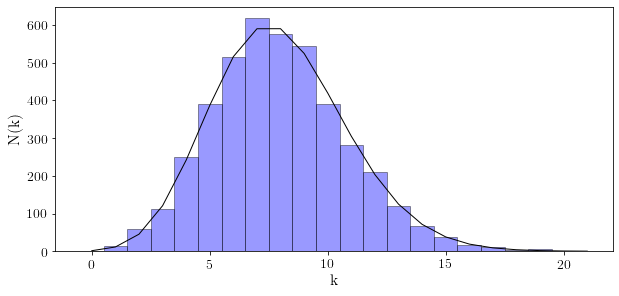

In [18]:
plt.xlabel(r"$\rm k$")
plt.ylabel(r'$\rm N(k)$')
plt.hist(degree_sequence,bins=range(0,int(maxk+2),1), align="left", histtype='bar', color="blue", alpha=0.4, edgecolor="black");
plt.plot(range(0,int(maxk+2),1),np.array(P(N,0,int(maxk+2),p))*N, linewidth=1, linestyle='-', c="black");

Wir stellen die epidemische Ausbreitung wieder in einer Animation dar, wobei wir in jedem Iterationsschritt jeden Spieler mit allen seinen Nachbarn in Kontakt treten lassen.

In [19]:
beta,mu,sterberate=0.2,0.1,0.01

Nx=65
Ny=65
N=int(Nx*Ny)
kbar=8
p=kbar/(N-1)
G = nx.erdos_renyi_graph(N, p)
PropPlayers=np.zeros([N,10])
Nframes=50
SIR=np.zeros([Nframes,4])

tval = np.linspace(0, Nframes, Nframes)

fig = plt.figure()
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1], wspace=0.3)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

def init():
    k=0
    ColorPlayer=[]
    for i in range(0,Nx):
        for j in range(0,Ny):
            PropPlayers[k].flat[0] = k #Knotennummer
            PropPlayers[k].flat[1] = i #x-Koordinate auf dem 2-D Gitter
            PropPlayers[k].flat[2] = j #y-Koordinate auf dem 2-D Gitter 
            if k==int(N/2):
                strategy=1 #entspricht I: Ansteckende Person
                ColorPlayer.append("red")
            else:
                strategy=0 #entspricht S: Gesunde Person
                ColorPlayer.append("blue")
            PropPlayers[k].flat[3] = strategy 
            k=k+1
    return fig,

def animate(i):
    ax1.cla()
    ax2.cla()
    for n in range(0,N):
        PropPlayers[n,4] == PropPlayers[n,3]
    for games in list(G.edges):
        if PropPlayers[games[0],3] == 1 and PropPlayers[games[1],3] == 0:
            PropPlayers[games[1]].flat[4]=MakeKontakt()
        if PropPlayers[games[1],3] == 1 and PropPlayers[games[0],3] == 0:
            PropPlayers[games[0]].flat[4]=MakeKontakt()   
    ColorPlayernew=[]
    ColorPlayer=[]
    for n in range(0,N):
        if PropPlayers[n,3] == 1:
            PropPlayers[n].flat[4]=GenesTot()
        if PropPlayers[n,4]==0:
            ColorPlayernew.append("blue")
        if PropPlayers[n,4]==1:
            ColorPlayernew.append("red")
        if PropPlayers[n,4]==2:
            ColorPlayernew.append("green")
        if PropPlayers[n,4]==3:
            ColorPlayernew.append("black")
        if PropPlayers[n,3]==0:
            SIR[i,0]=SIR[i,0]+1
            ColorPlayer.append("blue")
        if PropPlayers[n,3]==1:
            SIR[i,1]=SIR[i,1]+1
            ColorPlayer.append("red")
        if PropPlayers[n,3]==2:
            SIR[i,2]=SIR[i,2]+1
            ColorPlayer.append("green") 
        if PropPlayers[n,3]==3:
            SIR[i,3]=SIR[i,3]+1
            ColorPlayer.append("black") 
        PropPlayers[n].flat[3] = PropPlayers[n,4]
    ax2.scatter(PropPlayers[:,1],PropPlayers[:,2],s=16,c=ColorPlayer,marker="s",alpha=1,edgecolor='none')
    ax2.set_xlim(-0.75, Nx-0.25)
    ax2.set_ylim(-0.75, Ny-0.25)
    ax2.set_ylabel(r"$\rm y$")
    ax2.set_xlabel(r"$\rm x$")
    ColorPlayer=ColorPlayernew
    
    ax1.plot(tval[:i], SIR[:i,0]/N,c="blue", label=r"$\rm s(t)$");
    ax1.plot(tval[:i], SIR[:i,1]/N,c="red", label=r"$\rm i(t)$");
    ax1.plot(tval[:i], (SIR[:i,2]+SIR[:i,3])/N,c="grey", label=r"$\rm r(t)$");
    ax1.set_xlabel(r"$\rm t$")
    ax1.set_ylabel(r"$\rm s,i,r(t)$")
    ax1.set_xlim(0, Nframes)
    ax1.set_ylim(0, 1)
    return fig,

ani = animation.FuncAnimation(fig,animate,init_func=init,frames=Nframes,interval=400)

plt.close(ani._fig)

HTML(ani.to_html5_video())

Wir stellen nun die epidemische Ausbreitung des Virus auf dem zufälligen Netzwerk im Fruchterman Reingold Layout dar ($N=20 \cdot 20 = 400$).

In [20]:
beta,mu,sterberate=0.2,0.1,0.01

Nx=20
Ny=20
N=int(Nx*Ny)
kbar=8
p=kbar/(N-1)
mink=0
while mink<1:
    G = nx.erdos_renyi_graph(N, p)
    degree_sequence = []
    for i in G.nodes():
        degree_sequence.append(G.degree(i))
    mink=min(degree_sequence)
PropPlayers=np.zeros([N,10])
Nframes=50
SIR=np.zeros([Nframes,4])

tval = np.linspace(0, Nframes, Nframes)

pos2d=nx.fruchterman_reingold_layout(G,dim=2)

fig = plt.figure()
gs = gridspec.GridSpec(1, 2, width_ratios=[1,2], wspace=0.3)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

def init():
    k=0
    ColorPlayer=[]
    for i in range(0,Nx):
        for j in range(0,Ny):
            PropPlayers[k].flat[0] = k #Knotennummer
            PropPlayers[k].flat[1] = pos2d[k][0] #x-Koordinate auf dem 2-D Gitter
            PropPlayers[k].flat[2] = pos2d[k][1] #y-Koordinate auf dem 2-D Gitter 
            if k==int(N/2):
                strategy=1 #entspricht I: Ansteckende Person
                ColorPlayer.append("red")
            else:
                strategy=0 #entspricht S: Gesunde Person
                ColorPlayer.append("blue")
            PropPlayers[k].flat[3] = strategy 
            k=k+1
    return fig,

def animate(i):
    ax1.cla()
    ax2.cla()
    for n in range(0,N):
        PropPlayers[n,4] == PropPlayers[n,3]
    for games in list(G.edges):
        ax2.plot([pos2d[games[0]][0],pos2d[games[1]][0]], [pos2d[games[0]][1],pos2d[games[1]][1]], alpha=0.3, linewidth=0.1, c="black")
        if PropPlayers[games[0],3] == 1 and PropPlayers[games[1],3] == 0:
            PropPlayers[games[1]].flat[4]=MakeKontakt()
        if PropPlayers[games[1],3] == 1 and PropPlayers[games[0],3] == 0:
            PropPlayers[games[0]].flat[4]=MakeKontakt()   
    ColorPlayernew=[]
    ColorPlayer=[]
    for n in range(0,N):
        if PropPlayers[n,3] == 1:
            PropPlayers[n].flat[4]=GenesTot()
        if PropPlayers[n,4]==0:
            ColorPlayernew.append("blue")
        if PropPlayers[n,4]==1:
            ColorPlayernew.append("red")
        if PropPlayers[n,4]==2:
            ColorPlayernew.append("green")
        if PropPlayers[n,4]==3:
            ColorPlayernew.append("black")
        if PropPlayers[n,3]==0:
            SIR[i,0]=SIR[i,0]+1
            ColorPlayer.append("blue")
        if PropPlayers[n,3]==1:
            SIR[i,1]=SIR[i,1]+1
            ColorPlayer.append("red")
        if PropPlayers[n,3]==2:
            SIR[i,2]=SIR[i,2]+1
            ColorPlayer.append("green") 
        if PropPlayers[n,3]==3:
            SIR[i,3]=SIR[i,3]+1
            ColorPlayer.append("black") 
        PropPlayers[n].flat[3] = PropPlayers[n,4]
    ax2.scatter(PropPlayers[:,1],PropPlayers[:,2],s=16,c=ColorPlayer,marker="o",alpha=1,edgecolor='none')
    ax2.axis('off')
    ColorPlayer=ColorPlayernew
    
    ax1.plot(tval[:i], SIR[:i,0]/N,c="blue", label=r"$\rm s(t)$");
    ax1.plot(tval[:i], SIR[:i,1]/N,c="red", label=r"$\rm i(t)$");
    ax1.plot(tval[:i], (SIR[:i,2]+SIR[:i,3])/N,c="grey", label=r"$\rm r(t)$");
    ax1.set_xlabel(r"$\rm t$")
    ax1.set_ylabel(r"$\rm s,i,r(t)$")
    ax1.set_xlim(0, Nframes)
    ax1.set_ylim(0, 1)
    return fig,

ani = animation.FuncAnimation(fig,animate,init_func=init,frames=Nframes,interval=400)

plt.close(ani._fig)

HTML(ani.to_html5_video())

Die Ausbreitung des Krankheitserregers auf einem zufälligen Netzwerk entwickelt sich viel schneller als auf einem räumlichen Netzwerk und die zeitliche Entwicklung stimmt besser mit den Vorhersagen des deterministischen SIR-Modells überein. Für kleine Zeiten erkennt man nun deutlich den exponentiellen Verlauf der Ausbreitung und das Virus breitet sich, verglichen mit den Resultaten des räumlichen Gitters viel schneller in der Population aus. 

Die Knoten mit hohem Knotengrad (Personen mit vielen Kontakten) infizieren sich schneller und verteilen das Virus an unterschiedliche Orte des Netzwerkes. Um dies genauer zu analysieren, betrachten wir uns die relative Anzahl der infizierten Personen mit Knotengrad k ($i_k(t)$) und stellen uns die k-abhängige relative gesamte Anzahl der 'removed'-Personen dar $r_k(t)$ dar. Um den Effekt besser zu verdeutlichen, reduzieren wir den durchschnittlichen Knotengrad auf ungefähr $<\! k \!>=4$ und betrachten eine Population aus $N=50 \cdot 50 = 2500$ Individuen.

In [21]:
def count_numbers(numbers,setnum):
    results = []
    counter = 0
    for number in numbers:
        if number == setnum:
            counter += 1
    return counter

In [22]:
beta,mu,sterberate=0.2,0.1,0.01

Nx=50
Ny=50
N=int(Nx*Ny)
kbar=4
p=kbar/(N-1)
mink=0
G = nx.erdos_renyi_graph(N, p)
degree_sequence = []
for i in G.nodes():
    degree_sequence.append(G.degree(i))
mink=min(degree_sequence)
maxk=max(degree_sequence)
PropPlayers=np.zeros([N,10])
Nframes=60
SIR=np.zeros([Nframes,4])

cmap = plt.cm.Greens
line_colors = cmap(np.linspace(0,1,maxk-mink+2))
IK=np.zeros([Nframes,maxk+1])
RK=np.zeros([Nframes,maxk+1])

tval = np.linspace(0, Nframes, Nframes)

pos2d=nx.fruchterman_reingold_layout(G,dim=2)

fig = plt.figure()
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1], wspace=0.3)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

def init():
    k=0
    ColorPlayer=[]
    for i in range(0,Nx):
        for j in range(0,Ny):
            PropPlayers[k].flat[0] = k #Knotennummer
            PropPlayers[k].flat[1] = pos2d[k][0] #x-Koordinate auf dem 2-D Gitter
            PropPlayers[k].flat[2] = pos2d[k][1] #y-Koordinate auf dem 2-D Gitter 
            if k==int(N/2):
                strategy=1 #entspricht I: Ansteckende Person
                ColorPlayer.append("red")
            else:
                strategy=0 #entspricht S: Gesunde Person
                ColorPlayer.append("blue")
            PropPlayers[k].flat[3] = strategy 
            k=k+1
    return fig,

def animate(i):
    ax1.cla()
    ax2.cla()
    for n in range(0,N):
        PropPlayers[n,4] == PropPlayers[n,3]
    for games in list(G.edges):
        if PropPlayers[games[0],3] == 1 and PropPlayers[games[1],3] == 0:
            PropPlayers[games[1]].flat[4]=MakeKontakt()
        if PropPlayers[games[1],3] == 1 and PropPlayers[games[0],3] == 0:
            PropPlayers[games[0]].flat[4]=MakeKontakt()   
    ColorPlayernew=[]
    ColorPlayer=[]
    for n in range(0,N):
        if PropPlayers[n,3] == 1:
            PropPlayers[n].flat[4]=GenesTot()
        if PropPlayers[n,4]==0:
            ColorPlayernew.append("blue")
        if PropPlayers[n,4]==1:
            ColorPlayernew.append("red")
        if PropPlayers[n,4]==2:
            ColorPlayernew.append("green")
        if PropPlayers[n,4]==3:
            ColorPlayernew.append("black")
        if PropPlayers[n,3]==0:
            SIR[i,0]=SIR[i,0]+1
            ColorPlayer.append("blue")
        if PropPlayers[n,3]==1:
            IK[i,G.degree(n)]=IK[i,G.degree(n)]+1
            SIR[i,1]=SIR[i,1]+1
            ColorPlayer.append("red")
        if PropPlayers[n,3]==2:
            RK[i,G.degree(n)]=RK[i,G.degree(n)]+1
            SIR[i,2]=SIR[i,2]+1
            ColorPlayer.append("green") 
        if PropPlayers[n,3]==3:
            RK[i,G.degree(n)]=RK[i,G.degree(n)]+1
            SIR[i,3]=SIR[i,3]+1
            ColorPlayer.append("black") 
        PropPlayers[n].flat[3] = PropPlayers[n,4]
    ax2.set_xlabel(r"$\rm k$")
    ax2.set_ylabel(r'$\rm N(k)$')
    ax2.hist(degree_sequence,bins=range(0,int(maxk+2),1), align="left", histtype='bar', color="blue", alpha=0.2, edgecolor="black");
    ax2.plot(range(0,int(maxk+2),1),np.array(P(N,0,int(maxk+2),p))*N, linewidth=1, linestyle='-', c="black");
    ColorPlayer=ColorPlayernew
    degree_sequencek=[]
    for deg in range(mink,maxk+1):
        degree_sequencek=degree_sequencek+[deg]*int(RK[i,deg])
        if count_numbers(degree_sequence,deg)>0:
            ax1.plot(tval[:i], RK[:i,deg]/count_numbers(degree_sequence,deg),c=line_colors[deg], linestyle='-');
    ax2.hist(degree_sequencek,bins=range(0,int(maxk+2),1), align="left", histtype='bar', color="green", alpha=0.8, edgecolor="black");
    
    ax1.plot(tval[:i], SIR[:i,0]/N,c="blue", label=r"$\rm s(t)$");
    ax1.plot(tval[:i], SIR[:i,1]/N,c="red", label=r"$\rm i(t)$");
#    for deg in [mink,mink+1,mink+2,maxk-2,maxk-1,maxk]:
#        if count_numbers(degree_sequence,deg)>0:
#            ax1.plot(tval[:i], RK[:i,deg]/count_numbers(degree_sequence,deg),c=line_colors[deg], linestyle='-');
    ax1.plot(tval[:i], (SIR[:i,2]+SIR[:i,3])/N,c="black", label=r"$\rm r(t)$");
    ax1.set_xlabel(r"$\rm t$")
    ax1.set_ylabel(r"$\rm s,i,r(t)$")
    ax1.set_xlim(0, Nframes)
    ax1.set_ylim(0, 1.1)
    return fig,

ani = animation.FuncAnimation(fig,animate,init_func=init,frames=Nframes,interval=400)

plt.close(ani._fig)

HTML(ani.to_html5_video())

In der linken Abbildung ist die simulierte Funktion $r(t)$ (schwarze Kurve) und die entsprechenden k-abhängigen Größen $r_k(t)$ (grüne Kurven) dargestellt. Die Farbabstufungen des Grüns sind so gewählt, dass das Grün je heller ist, desto kleiner der Knotengrad k ist. Die rechte Abbildung stellt die Verteilungsfunktion der Knotengrade in dem erzeugten zufälligem Netzwerk dar (hellblaue Balken) und die einzelnen Werte von $r_k$ werden als grünen Balken dargestellt. Die beiden Animationen zeigen, dass sich die Personen mit hohem Knotengrad im Mittel schneller und mehr infizieren als Personen mit geringem Knotengrad. 

Diese Eigenschaft wird in Kapitel 10 des Online-Buchs 'Network Science' von Albert-Laszlo Barabasi mittels der 'degree block'-Approximation analysiert (siehe Image 10.9 in <A href="http://networksciencebook.com/chapter/10" target=blank>Chapter 10: Spreading phenomena</A>). 

Nun soll das zugrundeliegende Kontakt-Netzwerk ein skalenfreies Netzwerk sein. Wir erzeugen dafür wieder den entsprechenden Graphen mittels der Python-NetworkX Funktion barabasi_albert_graph. Wieder betrachten wir zunächst den Fall $N=400$ und  $<\! k \!> \approx 8$.

In [23]:
beta,mu,sterberate=0.2,0.1,0.01

Nx=20
Ny=20
N=int(Nx*Ny)
kbar=8
K=int(kbar/2)

G=nx.barabasi_albert_graph(N,K)

sumki=0
for i in G.nodes():
    sumki=sumki+G.degree()[i]
avki=sumki/N
print("kbar=",avki)

PropPlayers=np.zeros([N,10])
Nframes=50
SIR=np.zeros([Nframes,4])

tval = np.linspace(0, Nframes, Nframes)

pos2d=nx.fruchterman_reingold_layout(G,dim=2)

fig = plt.figure()
gs = gridspec.GridSpec(1, 2, width_ratios=[1,2], wspace=0.3)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

def init():
    k=0
    ColorPlayer=[]
    for i in range(0,Nx):
        for j in range(0,Ny):
            PropPlayers[k].flat[0] = k #Knotennummer
            PropPlayers[k].flat[1] = pos2d[k][0] #x-Koordinate auf dem 2-D Gitter
            PropPlayers[k].flat[2] = pos2d[k][1] #y-Koordinate auf dem 2-D Gitter 
            if k==int(N/2):
                strategy=1 #entspricht I: Ansteckende Person
                ColorPlayer.append("red")
            else:
                strategy=0 #entspricht S: Gesunde Person
                ColorPlayer.append("blue")
            PropPlayers[k].flat[3] = strategy 
            k=k+1
    return fig,

def animate(i):
    ax1.cla()
    ax2.cla()
    for n in range(0,N):
        PropPlayers[n,4] == PropPlayers[n,3]
    for games in list(G.edges):
        ax2.plot([pos2d[games[0]][0],pos2d[games[1]][0]], [pos2d[games[0]][1],pos2d[games[1]][1]], alpha=0.3, linewidth=0.1, c="black")
        if PropPlayers[games[0],3] == 1 and PropPlayers[games[1],3] == 0:
            PropPlayers[games[1]].flat[4]=MakeKontakt()
        if PropPlayers[games[1],3] == 1 and PropPlayers[games[0],3] == 0:
            PropPlayers[games[0]].flat[4]=MakeKontakt()   
    ColorPlayernew=[]
    ColorPlayer=[]
    for n in range(0,N):
        if PropPlayers[n,3] == 1:
            PropPlayers[n].flat[4]=GenesTot()
        if PropPlayers[n,4]==0:
            ColorPlayernew.append("blue")
        if PropPlayers[n,4]==1:
            ColorPlayernew.append("red")
        if PropPlayers[n,4]==2:
            ColorPlayernew.append("green")
        if PropPlayers[n,4]==3:
            ColorPlayernew.append("black")
        if PropPlayers[n,3]==0:
            SIR[i,0]=SIR[i,0]+1
            ColorPlayer.append("blue")
        if PropPlayers[n,3]==1:
            SIR[i,1]=SIR[i,1]+1
            ColorPlayer.append("red")
        if PropPlayers[n,3]==2:
            SIR[i,2]=SIR[i,2]+1
            ColorPlayer.append("green") 
        if PropPlayers[n,3]==3:
            SIR[i,3]=SIR[i,3]+1
            ColorPlayer.append("black") 
        PropPlayers[n].flat[3] = PropPlayers[n,4]
    ax2.scatter(PropPlayers[:,1],PropPlayers[:,2],s=16,c=ColorPlayer,marker="o",alpha=1,edgecolor='none')
    ax2.axis('off')
    ColorPlayer=ColorPlayernew
    
    ax1.plot(tval[:i], SIR[:i,0]/N,c="blue", label=r"$\rm s(t)$");
    ax1.plot(tval[:i], SIR[:i,1]/N,c="red", label=r"$\rm i(t)$");
    ax1.plot(tval[:i], (SIR[:i,2]+SIR[:i,3])/N,c="grey", label=r"$\rm r(t)$");
    ax1.set_xlabel(r"$\rm t$")
    ax1.set_ylabel(r"$\rm s,i,r(t)$")
    ax1.set_xlim(0, Nframes)
    ax1.set_ylim(0, 1)
    return fig,

ani = animation.FuncAnimation(fig,animate,init_func=init,frames=Nframes,interval=400)

plt.close(ani._fig)

HTML(ani.to_html5_video())

kbar= 7.92


Wir betrachten uns wieder die relative Anzahl der infizierten Personen mit Knotengrad k ($i_k(t)$) und stellen uns die k-abhängige relative gesamte Anzahl der 'removed'-Personen dar $r_k(t)$ dar ($N=600$ und  $<\! k \!> \approx 4$).

In [24]:
beta,mu,sterberate=0.2,0.1,0.01

Nx=25
Ny=25
N=int(Nx*Ny)
kbar=4
K=int(kbar/2)
p=kbar/(N-1)

G=nx.barabasi_albert_graph(N,K)

sumki=0
for i in G.nodes():
    sumki=sumki+G.degree()[i]
avki=sumki/N
print("kbar=",avki)

mink=0
degree_sequence = []
for i in G.nodes():
    degree_sequence.append(G.degree(i))
mink=min(degree_sequence)
maxk=max(degree_sequence)
PropPlayers=np.zeros([N,10])
Nframes=60
SIR=np.zeros([Nframes,4])

cmap = plt.cm.Greens
line_colors = cmap(np.linspace(0,1,maxk-mink+2))
IK=np.zeros([Nframes,maxk+1])
RK=np.zeros([Nframes,maxk+1])

tval = np.linspace(0, Nframes, Nframes)

pos2d=nx.fruchterman_reingold_layout(G,dim=2)

fig = plt.figure()
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1], wspace=0.3)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

def init():
    k=0
    ColorPlayer=[]
    for i in range(0,Nx):
        for j in range(0,Ny):
            PropPlayers[k].flat[0] = k #Knotennummer
            PropPlayers[k].flat[1] = pos2d[k][0] #x-Koordinate auf dem 2-D Gitter
            PropPlayers[k].flat[2] = pos2d[k][1] #y-Koordinate auf dem 2-D Gitter 
            if k==int(N/2):
                strategy=1 #entspricht I: Ansteckende Person
                ColorPlayer.append("red")
            else:
                strategy=0 #entspricht S: Gesunde Person
                ColorPlayer.append("blue")
            PropPlayers[k].flat[3] = strategy 
            k=k+1
    return fig,

def animate(i):
    ax1.cla()
    ax2.cla()
    for n in range(0,N):
        PropPlayers[n,4] == PropPlayers[n,3]
    for games in list(G.edges):
        if PropPlayers[games[0],3] == 1 and PropPlayers[games[1],3] == 0:
            PropPlayers[games[1]].flat[4]=MakeKontakt()
        if PropPlayers[games[1],3] == 1 and PropPlayers[games[0],3] == 0:
            PropPlayers[games[0]].flat[4]=MakeKontakt()   
    ColorPlayernew=[]
    ColorPlayer=[]
    for n in range(0,N):
        if PropPlayers[n,3] == 1:
            PropPlayers[n].flat[4]=GenesTot()
        if PropPlayers[n,4]==0:
            ColorPlayernew.append("blue")
        if PropPlayers[n,4]==1:
            ColorPlayernew.append("red")
        if PropPlayers[n,4]==2:
            ColorPlayernew.append("green")
        if PropPlayers[n,4]==3:
            ColorPlayernew.append("black")
        if PropPlayers[n,3]==0:
            SIR[i,0]=SIR[i,0]+1
            ColorPlayer.append("blue")
        if PropPlayers[n,3]==1:
            IK[i,G.degree(n)]=IK[i,G.degree(n)]+1
            SIR[i,1]=SIR[i,1]+1
            ColorPlayer.append("red")
        if PropPlayers[n,3]==2:
            RK[i,G.degree(n)]=RK[i,G.degree(n)]+1
            SIR[i,2]=SIR[i,2]+1
            ColorPlayer.append("green") 
        if PropPlayers[n,3]==3:
            RK[i,G.degree(n)]=RK[i,G.degree(n)]+1
            SIR[i,3]=SIR[i,3]+1
            ColorPlayer.append("black") 
        PropPlayers[n].flat[3] = PropPlayers[n,4]
    ax2.set_xlabel(r"$\rm k$")
    ax2.set_ylabel(r'$\rm N(k)$')
#    ax2.set_yscale('log')
    ax2.hist(degree_sequence,bins=range(0,int(maxk+2),1), align="left", histtype='bar', color="blue", alpha=0.2, edgecolor="black");
    ColorPlayer=ColorPlayernew
    degree_sequencek=[]
    for deg in range(mink,maxk+1):
        degree_sequencek=degree_sequencek+[deg]*int(RK[i,deg])
#        if count_numbers(degree_sequence,deg)>0:
#            ax1.plot(tval[:i], RK[:i,deg]/count_numbers(degree_sequence,deg),c=line_colors[deg], linestyle='-');
    ax2.hist(degree_sequencek,bins=range(0,int(maxk+2),1), align="left", histtype='bar', color="green", alpha=0.8, edgecolor="black");
    
    ax1.plot(tval[:i], SIR[:i,0]/N,c="blue", label=r"$\rm s(t)$");
    ax1.plot(tval[:i], SIR[:i,1]/N,c="red", label=r"$\rm i(t)$");
#    for deg in [mink,mink+1,mink+2,maxk-2,maxk-1,maxk]:
#        if count_numbers(degree_sequence,deg)>0:
#            ax1.plot(tval[:i], RK[:i,deg]/count_numbers(degree_sequence,deg),c=line_colors[deg], linestyle='-');
    ax1.plot(tval[:i], (SIR[:i,2]+SIR[:i,3])/N,c="black", label=r"$\rm r(t)$");
    ax1.set_xlabel(r"$\rm t$")
    ax1.set_ylabel(r"$\rm s,i,r(t)$")
    ax1.set_xlim(0, Nframes)
    ax1.set_ylim(0, 1.1)
    return fig,

ani = animation.FuncAnimation(fig,animate,init_func=init,frames=Nframes,interval=400)

plt.close(ani._fig)

HTML(ani.to_html5_video())

kbar= 3.9872


Man erkennt wieder, dass sich die Personen mit niedrigerem Knotengrad viel weniger oft infizieren als die Knoten mit hohem Knotengrad. 

Im Folgenden betrachten wir ($N=900$ und  $<\! k \!> \approx 2$.

In [25]:
beta,mu,sterberate=0.4,0.1,0.01

Nx=30
Ny=30
N=int(Nx*Ny)
kbar=2
K=int(kbar/2)

G=nx.barabasi_albert_graph(N,K)

sumki=0
for i in G.nodes():
    sumki=sumki+G.degree()[i]
avki=sumki/N
print("kbar=",avki)
print("R0=",beta*avki/mu)

PropPlayers=np.zeros([N,10])
Nframes=50
SIR=np.zeros([Nframes,4])

tval = np.linspace(0, Nframes, Nframes)

pos2d=nx.fruchterman_reingold_layout(G,dim=2)

fig = plt.figure()
gs = gridspec.GridSpec(1, 2, width_ratios=[1,2], wspace=0.3)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

def init():
    k=0
    ColorPlayer=[]
    for i in range(0,Nx):
        for j in range(0,Ny):
            PropPlayers[k].flat[0] = k #Knotennummer
            PropPlayers[k].flat[1] = pos2d[k][0] #x-Koordinate auf dem 2-D Gitter
            PropPlayers[k].flat[2] = pos2d[k][1] #y-Koordinate auf dem 2-D Gitter 
            if k==int(N/2):
                strategy=1 #entspricht I: Ansteckende Person
                ColorPlayer.append("red")
            else:
                strategy=0 #entspricht S: Gesunde Person
                ColorPlayer.append("blue")
            PropPlayers[k].flat[3] = strategy 
            k=k+1
    return fig,

def animate(i):
    ax1.cla()
    ax2.cla()
    for n in range(0,N):
        PropPlayers[n,4] == PropPlayers[n,3]
    for games in list(G.edges):
        ax2.plot([pos2d[games[0]][0],pos2d[games[1]][0]], [pos2d[games[0]][1],pos2d[games[1]][1]], alpha=0.3, linewidth=0.1, c="black")
        if PropPlayers[games[0],3] == 1 and PropPlayers[games[1],3] == 0:
            PropPlayers[games[1]].flat[4]=MakeKontakt()
        if PropPlayers[games[1],3] == 1 and PropPlayers[games[0],3] == 0:
            PropPlayers[games[0]].flat[4]=MakeKontakt()   
    ColorPlayernew=[]
    ColorPlayer=[]
    for n in range(0,N):
        if PropPlayers[n,3] == 1:
            PropPlayers[n].flat[4]=GenesTot()
        if PropPlayers[n,4]==0:
            ColorPlayernew.append("blue")
        if PropPlayers[n,4]==1:
            ColorPlayernew.append("red")
        if PropPlayers[n,4]==2:
            ColorPlayernew.append("green")
        if PropPlayers[n,4]==3:
            ColorPlayernew.append("black")
        if PropPlayers[n,3]==0:
            SIR[i,0]=SIR[i,0]+1
            ColorPlayer.append("blue")
        if PropPlayers[n,3]==1:
            SIR[i,1]=SIR[i,1]+1
            ColorPlayer.append("red")
        if PropPlayers[n,3]==2:
            SIR[i,2]=SIR[i,2]+1
            ColorPlayer.append("green") 
        if PropPlayers[n,3]==3:
            SIR[i,3]=SIR[i,3]+1
            ColorPlayer.append("black") 
        PropPlayers[n].flat[3] = PropPlayers[n,4]
    ax2.scatter(PropPlayers[:,1],PropPlayers[:,2],s=16,c=ColorPlayer,marker="o",alpha=1,edgecolor='none')
    ax2.axis('off')
    ColorPlayer=ColorPlayernew
    
    ax1.plot(tval[:i], SIR[:i,0]/N,c="blue", label=r"$\rm s(t)$");
    ax1.plot(tval[:i], SIR[:i,1]/N,c="red", label=r"$\rm i(t)$");
    ax1.plot(tval[:i], (SIR[:i,2]+SIR[:i,3])/N,c="grey", label=r"$\rm r(t)$");
    ax1.set_xlabel(r"$\rm t$")
    ax1.set_ylabel(r"$\rm s,i,r(t)$")
    ax1.set_xlim(0, Nframes)
    ax1.set_ylim(0, 1)
    return fig,

ani = animation.FuncAnimation(fig,animate,init_func=init,frames=Nframes,interval=400)

plt.close(ani._fig)

HTML(ani.to_html5_video())

kbar= 1.9977777777777779
R0= 7.9911111111111115


Die obige Animation zeigt, dass sich das Virus nicht mehr über die gesamte Population ausbreitet und dies sogar, obwohl der $R_0$-Wert hoch ist ($R_0 \approx 8$). Im deterministischen SIR-Model war dies auch zu beobachten, jedoch erst bei einem deutlich kleineren $R_0$-Wert. Wir wollen diese Eigenschaft genauer untersuchen.

Das folgende Bild vergleicht die Resultate von jeweils 300 epidemischen Simulationen, durchgeführt auf einem skalenfreien Netzwerk und einem zufälligen Netzwerk. Beide Netzwerke bestehen aus $N=900$ Personen und die Parameter der Netzwerke wurden so gewählt, dass $<\! k \!> \approx 2$ ist. Die epidemischen Parameter waren ebenfalls identisch: $\beta=0.4,\, \mu=0.1\,\, \rightarrow \, R_0 \approx 8$. Die 300 Simulationen unterschieden sich lediglich in der Position des infizierten Anfangsknotens.

kbar= 1.9977777777777779
R0= 7.9911111111111115


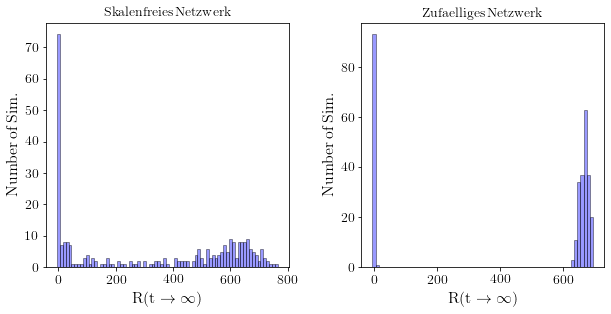

In [26]:
beta,mu,sterberate=0.4,0.1,0.01
Nensemble=300
Nframes=100

Nx=30
Ny=30
N=int(Nx*Ny)
kbar=2
K=int(kbar/2)

G=nx.barabasi_albert_graph(N,K)

sumki=0
for i in G.nodes():
    sumki=sumki+G.degree()[i]
avki=sumki/N
print("kbar=",avki)
print("R0=",beta*avki/mu)

tval = np.linspace(0, Nframes, Nframes)

fig = plt.figure()
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1], wspace=0.3)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ens_sequence=[]
for ens in range(0,Nensemble):
    PropPlayers=np.zeros([N,10])
    SIR=np.zeros([Nframes,4])
    ZeroPerson=randint(0, N-1)
    k=0
    ColorPlayer=[]
    for i in range(0,Nx):
        for j in range(0,Ny):
            PropPlayers[k].flat[0] = k #Knotennummer
            PropPlayers[k].flat[1] = i #x-Koordinate auf dem 2-D Gitter
            PropPlayers[k].flat[2] = j #y-Koordinate auf dem 2-D Gitter 
            if k==ZeroPerson:
                strategy=1 #entspricht I: Ansteckende Person
                ColorPlayer.append("red")
            else:
                strategy=0 #entspricht S: Gesunde Person
                ColorPlayer.append("blue")
            PropPlayers[k].flat[3] = strategy 
            k=k+1

    for i in range(0,Nframes):
        for n in range(0,N):
            PropPlayers[n,4] == PropPlayers[n,3]
        for games in list(G.edges):
            if PropPlayers[games[0],3] == 1 and PropPlayers[games[1],3] == 0:
                PropPlayers[games[1]].flat[4]=MakeKontakt()
            if PropPlayers[games[1],3] == 1 and PropPlayers[games[0],3] == 0:
                PropPlayers[games[0]].flat[4]=MakeKontakt()   
        ColorPlayernew=[]
        ColorPlayer=[]
        for n in range(0,N):
            if PropPlayers[n,3] == 1:
                PropPlayers[n].flat[4]=GenesTot()
            if PropPlayers[n,4]==0:
                ColorPlayernew.append("blue")
            if PropPlayers[n,4]==1:
                ColorPlayernew.append("red")
            if PropPlayers[n,4]==2:
                ColorPlayernew.append("green")
            if PropPlayers[n,4]==3:
                ColorPlayernew.append("black")
            if PropPlayers[n,3]==0:
                SIR[i,0]=SIR[i,0]+1
                ColorPlayer.append("blue")
            if PropPlayers[n,3]==1:
                SIR[i,1]=SIR[i,1]+1
                ColorPlayer.append("red")
            if PropPlayers[n,3]==2:
                SIR[i,2]=SIR[i,2]+1
                ColorPlayer.append("green") 
            if PropPlayers[n,3]==3:
                SIR[i,3]=SIR[i,3]+1
                ColorPlayer.append("black") 
            PropPlayers[n].flat[3] = PropPlayers[n,4]
        ColorPlayer=ColorPlayernew
    ens_sequence.append((SIR[Nframes-1,2]+SIR[Nframes-1,3]))
ax1.set_xlabel(r"$\rm R(t \rightarrow \infty)$")
ax1.set_ylabel(r'$\rm Number \, of \, Sim.$')
ax1.hist(ens_sequence,bins=range(0,int(max(ens_sequence))+2,10), align="left", histtype='bar', color="blue", alpha=0.4, edgecolor="black");


kbar=2
K=int(kbar/2)

p=kbar/(N-1)
mink=0
G = nx.erdos_renyi_graph(N, p)

sumki=0
for i in G.nodes():
    sumki=sumki+G.degree()[i]
avki=sumki/N
#print("kbar=",avki)
#print("R0=",beta*avki/mu)

ens_sequence=[]
for ens in range(0,Nensemble):
    PropPlayers=np.zeros([N,10])
    SIR=np.zeros([Nframes,4])
    ZeroPerson=randint(0, N-1)
    k=0
    ColorPlayer=[]
    for i in range(0,Nx):
        for j in range(0,Ny):
            PropPlayers[k].flat[0] = k #Knotennummer
            PropPlayers[k].flat[1] = i #x-Koordinate auf dem 2-D Gitter
            PropPlayers[k].flat[2] = j #y-Koordinate auf dem 2-D Gitter 
            if k==ZeroPerson:
                strategy=1 #entspricht I: Ansteckende Person
                ColorPlayer.append("red")
            else:
                strategy=0 #entspricht S: Gesunde Person
                ColorPlayer.append("blue")
            PropPlayers[k].flat[3] = strategy 
            k=k+1

    for i in range(0,Nframes):
        for n in range(0,N):
            PropPlayers[n,4] == PropPlayers[n,3]
        for games in list(G.edges):
            if PropPlayers[games[0],3] == 1 and PropPlayers[games[1],3] == 0:
                PropPlayers[games[1]].flat[4]=MakeKontakt()
            if PropPlayers[games[1],3] == 1 and PropPlayers[games[0],3] == 0:
                PropPlayers[games[0]].flat[4]=MakeKontakt()   
        ColorPlayernew=[]
        ColorPlayer=[]
        for n in range(0,N):
            if PropPlayers[n,3] == 1:
                PropPlayers[n].flat[4]=GenesTot()
            if PropPlayers[n,4]==0:
                ColorPlayernew.append("blue")
            if PropPlayers[n,4]==1:
                ColorPlayernew.append("red")
            if PropPlayers[n,4]==2:
                ColorPlayernew.append("green")
            if PropPlayers[n,4]==3:
                ColorPlayernew.append("black")
            if PropPlayers[n,3]==0:
                SIR[i,0]=SIR[i,0]+1
                ColorPlayer.append("blue")
            if PropPlayers[n,3]==1:
                SIR[i,1]=SIR[i,1]+1
                ColorPlayer.append("red")
            if PropPlayers[n,3]==2:
                SIR[i,2]=SIR[i,2]+1
                ColorPlayer.append("green") 
            if PropPlayers[n,3]==3:
                SIR[i,3]=SIR[i,3]+1
                ColorPlayer.append("black") 
            PropPlayers[n].flat[3] = PropPlayers[n,4]
        ColorPlayer=ColorPlayernew
    ens_sequence.append((SIR[Nframes-1,2]+SIR[Nframes-1,3]))
ax2.set_xlabel(r"$\rm R(t \rightarrow \infty)$")
ax2.set_ylabel(r'$\rm Number \, of \, Sim.$')
ax2.hist(ens_sequence,bins=range(0,int(max(ens_sequence))+2,10), align="left", histtype='bar', color="blue", alpha=0.4, edgecolor="black");
ax1.set_title(r'$\rm Skalenfreies \, Netzwerk$')
ax2.set_title(r'$\rm Zufaelliges \, Netzwerk$');

Die obige Abbildung zeigt die Anzahl der Simulationen, die einen epidemischen Endzustand von $R(t \rightarrow \infty)$ erreichen. $R(t \rightarrow \infty)$ beschreibt hier die Anzahl der während der gesamten Simulation infizierten Personen und somit ist $900-R(t \rightarrow \infty)=S(t \rightarrow \infty)$ die Anzahl der Personen, die während der gesamten Epidemie nicht infiziert wurden. Man erkennt einen deutlichen Unterschied zwischen den Ergebnissen des skalenfreien Netzwerks und dem zufälligen Netzwerk. 

Im zufälligen Netzwerk (rechte Abbildung) gibt es eine Vielzahl an Simulationen, in denen sich das Virus überhaupt nicht ausbreitet ($R(t \rightarrow \infty) \approx 0$), breitet es sich jedoch aus, dann infiziert es eine bestimmte Anzahl von Personen, wobei die Anzahl der mit dem Virus in Kontakt gekommenen Personen in einem stark geclusterten Bereich um $R(t \rightarrow \infty) \approx 650$ liegt. 

In sklalenfreien Netzwerken (linke Abbildung) gibt es auch eine Vielzahl an Simulationen, in denen sich das Virus überhaupt nicht ausbreitet ($R(t \rightarrow \infty) \approx 0$). Bei einer Ausbreitung des Virus ist der $R(t \rightarrow \infty)$-Wert jedoch nicht so stark geclusterten wie im zufälligen Netzwerk.

Wir verändern die Parameter des Systems, sodass $R_0 \approx 2$ ist. 

kbar= 1.9977777777777779
R0= 1.9977777777777779


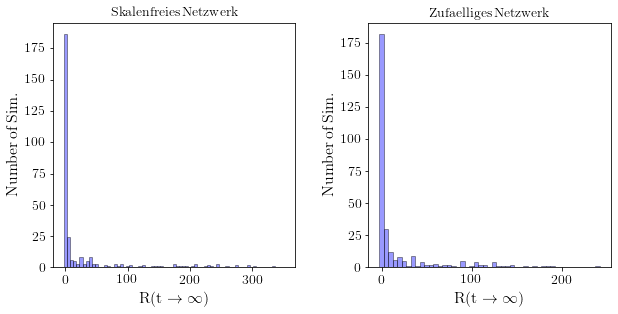

In [27]:
beta,mu,sterberate=0.1,0.1,0.01
Nensemble=300
Nframes=100

Nx=30
Ny=30
N=int(Nx*Ny)
kbar=2
K=int(kbar/2)

G=nx.barabasi_albert_graph(N,K)

sumki=0
for i in G.nodes():
    sumki=sumki+G.degree()[i]
avki=sumki/N
print("kbar=",avki)
print("R0=",beta*avki/mu)

ens_sequence=[]

tval = np.linspace(0, Nframes, Nframes)

fig = plt.figure()
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1], wspace=0.3)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

for ens in range(0,Nensemble):
    PropPlayers=np.zeros([N,10])
    SIR=np.zeros([Nframes,4])
    ZeroPerson=randint(0, N-1)
    k=0
    ColorPlayer=[]
    for i in range(0,Nx):
        for j in range(0,Ny):
            PropPlayers[k].flat[0] = k #Knotennummer
            PropPlayers[k].flat[1] = i #x-Koordinate auf dem 2-D Gitter
            PropPlayers[k].flat[2] = j #y-Koordinate auf dem 2-D Gitter 
            if k==ZeroPerson:
                strategy=1 #entspricht I: Ansteckende Person
                ColorPlayer.append("red")
            else:
                strategy=0 #entspricht S: Gesunde Person
                ColorPlayer.append("blue")
            PropPlayers[k].flat[3] = strategy 
            k=k+1

    for i in range(0,Nframes):
        for n in range(0,N):
            PropPlayers[n,4] == PropPlayers[n,3]
        for games in list(G.edges):
            if PropPlayers[games[0],3] == 1 and PropPlayers[games[1],3] == 0:
                PropPlayers[games[1]].flat[4]=MakeKontakt()
            if PropPlayers[games[1],3] == 1 and PropPlayers[games[0],3] == 0:
                PropPlayers[games[0]].flat[4]=MakeKontakt()   
        ColorPlayernew=[]
        ColorPlayer=[]
        for n in range(0,N):
            if PropPlayers[n,3] == 1:
                PropPlayers[n].flat[4]=GenesTot()
            if PropPlayers[n,4]==0:
                ColorPlayernew.append("blue")
            if PropPlayers[n,4]==1:
                ColorPlayernew.append("red")
            if PropPlayers[n,4]==2:
                ColorPlayernew.append("green")
            if PropPlayers[n,4]==3:
                ColorPlayernew.append("black")
            if PropPlayers[n,3]==0:
                SIR[i,0]=SIR[i,0]+1
                ColorPlayer.append("blue")
            if PropPlayers[n,3]==1:
                SIR[i,1]=SIR[i,1]+1
                ColorPlayer.append("red")
            if PropPlayers[n,3]==2:
                SIR[i,2]=SIR[i,2]+1
                ColorPlayer.append("green") 
            if PropPlayers[n,3]==3:
                SIR[i,3]=SIR[i,3]+1
                ColorPlayer.append("black") 
            PropPlayers[n].flat[3] = PropPlayers[n,4]
        ColorPlayer=ColorPlayernew
    ens_sequence.append((SIR[Nframes-1,2]+SIR[Nframes-1,3]))
ax1.set_xlabel(r"$\rm R(t \rightarrow \infty)$")
ax1.set_ylabel(r'$\rm Number \, of \, Sim.$')
ax1.hist(ens_sequence,bins=range(0,int(max(ens_sequence))+2,5), align="left", histtype='bar', color="blue", alpha=0.4, edgecolor="black");


kbar=2
K=int(kbar/2)

p=kbar/(N-1)
mink=0
G = nx.erdos_renyi_graph(N, p)

sumki=0
for i in G.nodes():
    sumki=sumki+G.degree()[i]
avki=sumki/N
#print("kbar=",avki)
#print("R0=",beta*avki/mu)

ens_sequence=[]

for ens in range(0,Nensemble):
    PropPlayers=np.zeros([N,10])
    SIR=np.zeros([Nframes,4])
    ZeroPerson=randint(0, N-1)
    k=0
    ColorPlayer=[]
    for i in range(0,Nx):
        for j in range(0,Ny):
            PropPlayers[k].flat[0] = k #Knotennummer
            PropPlayers[k].flat[1] = i #x-Koordinate auf dem 2-D Gitter
            PropPlayers[k].flat[2] = j #y-Koordinate auf dem 2-D Gitter 
            if k==ZeroPerson:
                strategy=1 #entspricht I: Ansteckende Person
                ColorPlayer.append("red")
            else:
                strategy=0 #entspricht S: Gesunde Person
                ColorPlayer.append("blue")
            PropPlayers[k].flat[3] = strategy 
            k=k+1

    for i in range(0,Nframes):
        for n in range(0,N):
            PropPlayers[n,4] == PropPlayers[n,3]
        for games in list(G.edges):
            if PropPlayers[games[0],3] == 1 and PropPlayers[games[1],3] == 0:
                PropPlayers[games[1]].flat[4]=MakeKontakt()
            if PropPlayers[games[1],3] == 1 and PropPlayers[games[0],3] == 0:
                PropPlayers[games[0]].flat[4]=MakeKontakt()   
        ColorPlayernew=[]
        ColorPlayer=[]
        for n in range(0,N):
            if PropPlayers[n,3] == 1:
                PropPlayers[n].flat[4]=GenesTot()
            if PropPlayers[n,4]==0:
                ColorPlayernew.append("blue")
            if PropPlayers[n,4]==1:
                ColorPlayernew.append("red")
            if PropPlayers[n,4]==2:
                ColorPlayernew.append("green")
            if PropPlayers[n,4]==3:
                ColorPlayernew.append("black")
            if PropPlayers[n,3]==0:
                SIR[i,0]=SIR[i,0]+1
                ColorPlayer.append("blue")
            if PropPlayers[n,3]==1:
                SIR[i,1]=SIR[i,1]+1
                ColorPlayer.append("red")
            if PropPlayers[n,3]==2:
                SIR[i,2]=SIR[i,2]+1
                ColorPlayer.append("green") 
            if PropPlayers[n,3]==3:
                SIR[i,3]=SIR[i,3]+1
                ColorPlayer.append("black") 
            PropPlayers[n].flat[3] = PropPlayers[n,4]
        ColorPlayer=ColorPlayernew
    ens_sequence.append((SIR[Nframes-1,2]+SIR[Nframes-1,3]))
ax2.set_xlabel(r"$\rm R(t \rightarrow \infty)$")
ax2.set_ylabel(r'$\rm Number \, of \, Sim.$')
ax2.hist(ens_sequence,bins=range(0,int(max(ens_sequence))+2,5), align="left", histtype='bar', color="blue", alpha=0.4, edgecolor="black");
ax1.set_title(r'$\rm Skalenfreies \, Netzwerk$')
ax2.set_title(r'$\rm Zufaelliges \, Netzwerk$');

Obwohl $R_0 \approx 2$ ist, stirbt das Virus bei einem Großteil der durchgeführten Simulationen schnell aus - dies ist ein wesentlicher Unterschied zum deterministischen SIR-Modell.

Nun soll das zugrundeliegende Kontakt-Netzwerk ein Watts-Strogatz "kleine Welt"-Netzwerk sein. Wir betrachten jedoch zunächst ein reguläres Ring-Netzwerk, wobei jeder Knoten mit seinem nächsten und übernächsten Nachbarn verbunden ist ($N=400$ und  $<\! k \!> = 4$) und simulieren wieder die epidemische Ausbreitung auf diesem Ringnetzwerk. 

In [28]:
beta,mu,sterberate=0.4,0.1,0.01

Nx=20
Ny=20
N=int(Nx*Ny)
kbar=4
p=kbar/(N-1)

G=nx.Graph()
G.add_nodes_from(range(0,N,1))
i=0
while i <= N-3:
    G.add_edge(i,i+1)
    G.add_edge(i,i+2)
    i=i+1
G.add_edge(N-2,N-1)  
G.add_edge(N-2,0)
G.add_edge(N-1,0)
G.add_edge(N-1,1)
PropPlayers=np.zeros([N,10])
Nframes=100
SIR=np.zeros([Nframes,4])

tval = np.linspace(0, Nframes, Nframes)

pos2d=nx.fruchterman_reingold_layout(G,dim=2)

fig = plt.figure()
gs = gridspec.GridSpec(1, 2, width_ratios=[1,2], wspace=0.3)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

def init():
    k=0
    ColorPlayer=[]
    for i in range(0,Nx):
        for j in range(0,Ny):
            PropPlayers[k].flat[0] = k #Knotennummer
            PropPlayers[k].flat[1] = pos2d[k][0] #x-Koordinate auf dem 2-D Gitter
            PropPlayers[k].flat[2] = pos2d[k][1] #y-Koordinate auf dem 2-D Gitter 
            if k==int(N/2):
                strategy=1 #entspricht I: Ansteckende Person
                ColorPlayer.append("red")
            else:
                strategy=0 #entspricht S: Gesunde Person
                ColorPlayer.append("blue")
            PropPlayers[k].flat[3] = strategy 
            k=k+1
    return fig,

def animate(i):
    ax1.cla()
    ax2.cla()
    for n in range(0,N):
        PropPlayers[n,4] == PropPlayers[n,3]
    for games in list(G.edges):
        ax2.plot([pos2d[games[0]][0],pos2d[games[1]][0]], [pos2d[games[0]][1],pos2d[games[1]][1]], alpha=0.3, linewidth=0.1, c="black")
        if PropPlayers[games[0],3] == 1 and PropPlayers[games[1],3] == 0:
            PropPlayers[games[1]].flat[4]=MakeKontakt()
        if PropPlayers[games[1],3] == 1 and PropPlayers[games[0],3] == 0:
            PropPlayers[games[0]].flat[4]=MakeKontakt()   
    ColorPlayernew=[]
    ColorPlayer=[]
    for n in range(0,N):
        if PropPlayers[n,3] == 1:
            PropPlayers[n].flat[4]=GenesTot()
        if PropPlayers[n,4]==0:
            ColorPlayernew.append("blue")
        if PropPlayers[n,4]==1:
            ColorPlayernew.append("red")
        if PropPlayers[n,4]==2:
            ColorPlayernew.append("green")
        if PropPlayers[n,4]==3:
            ColorPlayernew.append("black")
        if PropPlayers[n,3]==0:
            SIR[i,0]=SIR[i,0]+1
            ColorPlayer.append("blue")
        if PropPlayers[n,3]==1:
            SIR[i,1]=SIR[i,1]+1
            ColorPlayer.append("red")
        if PropPlayers[n,3]==2:
            SIR[i,2]=SIR[i,2]+1
            ColorPlayer.append("green") 
        if PropPlayers[n,3]==3:
            SIR[i,3]=SIR[i,3]+1
            ColorPlayer.append("black") 
        PropPlayers[n].flat[3] = PropPlayers[n,4]
    ax2.scatter(PropPlayers[:,1],PropPlayers[:,2],s=16,c=ColorPlayer,marker="o",alpha=1,edgecolor='none')
    ax2.axis('off')
    ColorPlayer=ColorPlayernew
    
    ax1.plot(tval[:i], SIR[:i,0]/N,c="blue", label=r"$\rm s(t)$");
    ax1.plot(tval[:i], SIR[:i,1]/N,c="red", label=r"$\rm i(t)$");
    ax1.plot(tval[:i], (SIR[:i,2]+SIR[:i,3])/N,c="grey", label=r"$\rm r(t)$");
    ax1.set_xlabel(r"$\rm t$")
    ax1.set_ylabel(r"$\rm s,i,r(t)$")
    ax1.set_xlim(0, Nframes)
    ax1.set_ylim(0, 1)
    return fig,

ani = animation.FuncAnimation(fig,animate,init_func=init,frames=Nframes,interval=400)

plt.close(ani._fig)

HTML(ani.to_html5_video())

Nun machen wir den Übergang zum Watts-Strogatz "kleine Welt"-Netzwerk: Wir starten hierbei mit unserem eindimensionalen Gitter-Netzwerk mit 400 Knoten, wobei jeder Knoten mit seinen 4-nächsten Nachbarn verbunden ist. Wir löschen 10 existierende Verbindungen (Kanten) und stellen 10 neue Kanten im Netzwerk in zufälliger Weise her. Wieder betrachten wir die epidemische Ausbreitung.

In [29]:
beta,mu,sterberate=0.4,0.1,0.01

Nx=20
Ny=20
N=int(Nx*Ny)
kbar=4
p=kbar/(N-1)
KleineWeltLinks=10

G=nx.Graph()
G.add_nodes_from(range(0,N,1))
i=0
while i <= N-3:
    G.add_edge(i,i+1)
    G.add_edge(i,i+2)
    i=i+1
G.add_edge(N-2,N-1)  
G.add_edge(N-2,0)
G.add_edge(N-1,0)
G.add_edge(N-1,1)

NewEdge=0
while NewEdge<=KleineWeltLinks:    
    KnA = randint(0, N-1)
    NeigList = list(G.neighbors(KnA))
    Neig = randint(0, len(NeigList)-1)
    KnB = NeigList[Neig]
    KnC = randint(0, N-1)
    if KnA != KnC and list(G.edges()).count((KnA,KnC))==0 and list(G.edges()).count((KnC,KnA))==0 and KnB != KnC:
        G.remove_edge(KnA, KnB)
        G.add_edge(KnA,KnC)
        NewEdge=NewEdge+1

PropPlayers=np.zeros([N,10])
Nframes=80
SIR=np.zeros([Nframes,4])

tval = np.linspace(0, Nframes, Nframes)

pos2d=nx.fruchterman_reingold_layout(G,dim=2)

fig = plt.figure()
gs = gridspec.GridSpec(1, 2, width_ratios=[1,2], wspace=0.3)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

def init():
    k=0
    ColorPlayer=[]
    for i in range(0,Nx):
        for j in range(0,Ny):
            PropPlayers[k].flat[0] = k #Knotennummer
            PropPlayers[k].flat[1] = pos2d[k][0] #x-Koordinate auf dem 2-D Gitter
            PropPlayers[k].flat[2] = pos2d[k][1] #y-Koordinate auf dem 2-D Gitter 
            if k==int(N/2):
                strategy=1 #entspricht I: Ansteckende Person
                ColorPlayer.append("red")
            else:
                strategy=0 #entspricht S: Gesunde Person
                ColorPlayer.append("blue")
            PropPlayers[k].flat[3] = strategy 
            k=k+1
    return fig,

def animate(i):
    ax1.cla()
    ax2.cla()
    for n in range(0,N):
        PropPlayers[n,4] == PropPlayers[n,3]
    for games in list(G.edges):
        ax2.plot([pos2d[games[0]][0],pos2d[games[1]][0]], [pos2d[games[0]][1],pos2d[games[1]][1]], alpha=0.3, linewidth=0.1, c="black")
        if PropPlayers[games[0],3] == 1 and PropPlayers[games[1],3] == 0:
            PropPlayers[games[1]].flat[4]=MakeKontakt()
        if PropPlayers[games[1],3] == 1 and PropPlayers[games[0],3] == 0:
            PropPlayers[games[0]].flat[4]=MakeKontakt()   
    ColorPlayernew=[]
    ColorPlayer=[]
    for n in range(0,N):
        if PropPlayers[n,3] == 1:
            PropPlayers[n].flat[4]=GenesTot()
        if PropPlayers[n,4]==0:
            ColorPlayernew.append("blue")
        if PropPlayers[n,4]==1:
            ColorPlayernew.append("red")
        if PropPlayers[n,4]==2:
            ColorPlayernew.append("green")
        if PropPlayers[n,4]==3:
            ColorPlayernew.append("black")
        if PropPlayers[n,3]==0:
            SIR[i,0]=SIR[i,0]+1
            ColorPlayer.append("blue")
        if PropPlayers[n,3]==1:
            SIR[i,1]=SIR[i,1]+1
            ColorPlayer.append("red")
        if PropPlayers[n,3]==2:
            SIR[i,2]=SIR[i,2]+1
            ColorPlayer.append("green") 
        if PropPlayers[n,3]==3:
            SIR[i,3]=SIR[i,3]+1
            ColorPlayer.append("black") 
        PropPlayers[n].flat[3] = PropPlayers[n,4]
    ax2.scatter(PropPlayers[:,1],PropPlayers[:,2],s=16,c=ColorPlayer,marker="o",alpha=1,edgecolor='none')
    ax2.axis('off')
    ColorPlayer=ColorPlayernew
    
    ax1.plot(tval[:i], SIR[:i,0]/N,c="blue", label=r"$\rm s(t)$");
    ax1.plot(tval[:i], SIR[:i,1]/N,c="red", label=r"$\rm i(t)$");
    ax1.plot(tval[:i], (SIR[:i,2]+SIR[:i,3])/N,c="grey", label=r"$\rm r(t)$");
    ax1.set_xlabel(r"$\rm t$")
    ax1.set_ylabel(r"$\rm s,i,r(t)$")
    ax1.set_xlim(0, Nframes)
    ax1.set_ylim(0, 1)
    return fig,

ani = animation.FuncAnimation(fig,animate,init_func=init,frames=Nframes,interval=400)

plt.close(ani._fig)

HTML(ani.to_html5_video())

Wir löschen nun 20 existierende Kanten und stellen jeweils 20 neue Kante im Netzwerk in zufälliger Weise her. Es ergibt sich die folgende epidemische Entwicklung:

In [30]:
beta,mu,sterberate=0.4,0.1,0.01

Nx=20
Ny=20
N=int(Nx*Ny)
kbar=4
p=kbar/(N-1)
KleineWeltLinks=20

G=nx.Graph()
G.add_nodes_from(range(0,N,1))
i=0
while i <= N-3:
    G.add_edge(i,i+1)
    G.add_edge(i,i+2)
    i=i+1
G.add_edge(N-2,N-1)  
G.add_edge(N-2,0)
G.add_edge(N-1,0)
G.add_edge(N-1,1)

NewEdge=0
while NewEdge<=KleineWeltLinks:    
    KnA = randint(0, N-1)
    NeigList = list(G.neighbors(KnA))
    Neig = randint(0, len(NeigList)-1)
    KnB = NeigList[Neig]
    KnC = randint(0, N-1)
    if KnA != KnC and list(G.edges()).count((KnA,KnC))==0 and list(G.edges()).count((KnC,KnA))==0 and KnB != KnC:
        G.remove_edge(KnA, KnB)
        G.add_edge(KnA,KnC)
        NewEdge=NewEdge+1

PropPlayers=np.zeros([N,10])
Nframes=80
SIR=np.zeros([Nframes,4])

tval = np.linspace(0, Nframes, Nframes)

pos2d=nx.fruchterman_reingold_layout(G,dim=2)

fig = plt.figure()
gs = gridspec.GridSpec(1, 2, width_ratios=[1,2], wspace=0.3)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

def init():
    k=0
    ColorPlayer=[]
    for i in range(0,Nx):
        for j in range(0,Ny):
            PropPlayers[k].flat[0] = k #Knotennummer
            PropPlayers[k].flat[1] = pos2d[k][0] #x-Koordinate auf dem 2-D Gitter
            PropPlayers[k].flat[2] = pos2d[k][1] #y-Koordinate auf dem 2-D Gitter 
            if k==int(N/2):
                strategy=1 #entspricht I: Ansteckende Person
                ColorPlayer.append("red")
            else:
                strategy=0 #entspricht S: Gesunde Person
                ColorPlayer.append("blue")
            PropPlayers[k].flat[3] = strategy 
            k=k+1
    return fig,

def animate(i):
    ax1.cla()
    ax2.cla()
    for n in range(0,N):
        PropPlayers[n,4] == PropPlayers[n,3]
    for games in list(G.edges):
        ax2.plot([pos2d[games[0]][0],pos2d[games[1]][0]], [pos2d[games[0]][1],pos2d[games[1]][1]], alpha=0.7, linewidth=0.1, c="black")
        if PropPlayers[games[0],3] == 1 and PropPlayers[games[1],3] == 0:
            PropPlayers[games[1]].flat[4]=MakeKontakt()
        if PropPlayers[games[1],3] == 1 and PropPlayers[games[0],3] == 0:
            PropPlayers[games[0]].flat[4]=MakeKontakt()   
    ColorPlayernew=[]
    ColorPlayer=[]
    for n in range(0,N):
        if PropPlayers[n,3] == 1:
            PropPlayers[n].flat[4]=GenesTot()
        if PropPlayers[n,4]==0:
            ColorPlayernew.append("blue")
        if PropPlayers[n,4]==1:
            ColorPlayernew.append("red")
        if PropPlayers[n,4]==2:
            ColorPlayernew.append("green")
        if PropPlayers[n,4]==3:
            ColorPlayernew.append("black")
        if PropPlayers[n,3]==0:
            SIR[i,0]=SIR[i,0]+1
            ColorPlayer.append("blue")
        if PropPlayers[n,3]==1:
            SIR[i,1]=SIR[i,1]+1
            ColorPlayer.append("red")
        if PropPlayers[n,3]==2:
            SIR[i,2]=SIR[i,2]+1
            ColorPlayer.append("green") 
        if PropPlayers[n,3]==3:
            SIR[i,3]=SIR[i,3]+1
            ColorPlayer.append("black") 
        PropPlayers[n].flat[3] = PropPlayers[n,4]
    ax2.scatter(PropPlayers[:,1],PropPlayers[:,2],s=16,c=ColorPlayer,marker="o",alpha=1,edgecolor='none')
    ax2.axis('off')
    ColorPlayer=ColorPlayernew
    
    ax1.plot(tval[:i], SIR[:i,0]/N,c="blue", label=r"$\rm s(t)$");
    ax1.plot(tval[:i], SIR[:i,1]/N,c="red", label=r"$\rm i(t)$");
    ax1.plot(tval[:i], (SIR[:i,2]+SIR[:i,3])/N,c="grey", label=r"$\rm r(t)$");
    ax1.set_xlabel(r"$\rm t$")
    ax1.set_ylabel(r"$\rm s,i,r(t)$")
    ax1.set_xlim(0, Nframes)
    ax1.set_ylim(0, 1)
    return fig,

ani = animation.FuncAnimation(fig,animate,init_func=init,frames=Nframes,interval=400)

plt.close(ani._fig)

HTML(ani.to_html5_video())

Nun soll das zugrundeliegende Kontakt-Netzwerk ein vollständig verbundenes Netzwerk sein. Wir erzeugen dafür wieder das entsprechende vollständig verbundene Kontakt-Netzwerk mit $N=35\cdot35=1225$ Personen, wobei wir in jedem Iterationsschritt jeden Spieler mit acht seinen Nachbarn in Kontakt treten lassen.

In [31]:
beta,mu,sterberate=0.2,0.1,0.01

Nx=35
Ny=35
N=int(Nx*Ny)
kbar=8
p=1
G = nx.erdos_renyi_graph(N, p)
PropPlayers=np.zeros([N,10])
Nframes=50
SIR=np.zeros([Nframes,4])

tval = np.linspace(0, Nframes, Nframes)

fig = plt.figure()
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1], wspace=0.3)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

def init():
    k=0
    ColorPlayer=[]
    for i in range(0,Nx):
        for j in range(0,Ny):
            PropPlayers[k].flat[0] = k #Knotennummer
            PropPlayers[k].flat[1] = i #x-Koordinate auf dem 2-D Gitter
            PropPlayers[k].flat[2] = j #y-Koordinate auf dem 2-D Gitter 
            if k==int(N/2):
                strategy=1 #entspricht I: Ansteckende Person
                ColorPlayer.append("red")
            else:
                strategy=0 #entspricht S: Gesunde Person
                ColorPlayer.append("blue")
            PropPlayers[k].flat[3] = strategy 
            k=k+1
    return fig,

def animate(i):
    ax.cla()
    for n in range(0,N):
        PropPlayers[n,4] == PropPlayers[n,3]
        if PropPlayers[n,3] == 1:
            while PropPlayers[n,5] <= kbar:
                KontaktMit=list(G.neighbors(n))[randint(0, len(list(G.neighbors(n)))-2)]
                PropPlayers[n,5]=PropPlayers[n,5]+1
                PropPlayers[KontaktMit,5]=PropPlayers[KontaktMit,5]+1
                if PropPlayers[KontaktMit,3] == 0 and PropPlayers[KontaktMit,5]<=kbar:
                    PropPlayers[KontaktMit].flat[4]=MakeKontakt()  
    ColorPlayernew=[]
    ColorPlayer=[]
    for n in range(0,N):
        if PropPlayers[n,3] == 1:
            PropPlayers[n].flat[4]=GenesTot()
        if PropPlayers[n,4]==0:
            ColorPlayernew.append("blue")
        if PropPlayers[n,4]==1:
            ColorPlayernew.append("red")
        if PropPlayers[n,4]==2:
            ColorPlayernew.append("green")
        if PropPlayers[n,4]==3:
            ColorPlayernew.append("black")
        if PropPlayers[n,3]==0:
            SIR[i,0]=SIR[i,0]+1
            ColorPlayer.append("blue")
        if PropPlayers[n,3]==1:
            SIR[i,1]=SIR[i,1]+1
            ColorPlayer.append("red")
        if PropPlayers[n,3]==2:
            SIR[i,2]=SIR[i,2]+1
            ColorPlayer.append("green") 
        if PropPlayers[n,3]==3:
            SIR[i,3]=SIR[i,3]+1
            ColorPlayer.append("black") 
        PropPlayers[n].flat[3] = PropPlayers[n,4]
        PropPlayers[n,5]=0
    ax2.scatter(PropPlayers[:,1],PropPlayers[:,2],s=34,c=ColorPlayer,marker="s",alpha=1,edgecolor='none')
    ax2.set_xlim(-0.75, Nx-0.25)
    ax2.set_ylim(-0.75, Ny-0.25)
    ax2.set_ylabel(r"$\rm y$")
    ax2.set_xlabel(r"$\rm x$")
    ColorPlayer=ColorPlayernew
    
    ax1.plot(tval[:i], SIR[:i,0]/N,c="blue", label=r"$\rm s(t)$");
    ax1.plot(tval[:i], SIR[:i,1]/N,c="red", label=r"$\rm i(t)$");
    ax1.plot(tval[:i], (SIR[:i,2]+SIR[:i,3])/N,c="grey", label=r"$\rm r(t)$");
    ax1.set_xlabel(r"$\rm t$")
    ax1.set_ylabel(r"$\rm s,i,r(t)$")
    ax1.set_xlim(0, Nframes)
    ax1.set_ylim(0, 1)
    return fig,

ani = animation.FuncAnimation(fig,animate,init_func=init,frames=Nframes,interval=400)

plt.close(ani._fig)

HTML(ani.to_html5_video())

Wir berechnen nun in gleicher Weise ein größeres Netzwerk $N=4225$ und vergleichen die Simulationsergebnisse mit den Vorhersagen des deterministischen SIR-Modells:

In [32]:
from scipy import integrate

def DGLs(s,i,r,beta,mu,k):
    fs = -beta*k*i*s
    return fs
def DGLi(s,i,r,beta,mu,k):
    fi = -mu*i + beta*k*i*s
    return fi
def DGLr(s,i,r,beta,mu,k):
    fr = +mu*i
    return fr

def DGLsys(vx,t):
    s, i, r = vx
    dsdt = DGLs(s,i,r,beta,mu,k)
    didt = DGLi(s,i,r,beta,mu,k)
    drdt = DGLr(s,i,r,beta,mu,k)
    return np.array([dsdt,didt,drdt])

In [33]:
N=65*65
beta,mu=0.2,0.1
k=8
#print("R0=",beta*k/mu)
tend=50

tsirval = np.linspace(0, tend, 1001)
s0=(N-1)/N
i0=1/N
r0=0
initialval = np.array([s0,i0,r0])
Loes = integrate.odeint(DGLsys, initialval, tsirval)

In [34]:
beta,mu,sterberate=0.2,0.1,0.01

Nx=65
Ny=65
N=int(Nx*Ny)
kbar=8
p=1
G = nx.erdos_renyi_graph(N, p)
PropPlayers=np.zeros([N,10])
Nframes=50
SIR=np.zeros([Nframes,4])

tval = np.linspace(0, Nframes, Nframes)

fig = plt.figure()
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1], wspace=0.3)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

def init():
    k=0
    ColorPlayer=[]
    for i in range(0,Nx):
        for j in range(0,Ny):
            PropPlayers[k].flat[0] = k #Knotennummer
            PropPlayers[k].flat[1] = i #x-Koordinate auf dem 2-D Gitter
            PropPlayers[k].flat[2] = j #y-Koordinate auf dem 2-D Gitter 
            if k==int(N/2):
                strategy=1 #entspricht I: Ansteckende Person
                ColorPlayer.append("red")
            else:
                strategy=0 #entspricht S: Gesunde Person
                ColorPlayer.append("blue")
            PropPlayers[k].flat[3] = strategy 
            k=k+1
    return fig,

def animate(i):
    ax.cla()
    for n in range(0,N):
        PropPlayers[n,4] == PropPlayers[n,3]
        if PropPlayers[n,3] == 1:
            while PropPlayers[n,5] < kbar:
                KontaktMit=list(G.neighbors(n))[randint(0, len(list(G.neighbors(n)))-2)]
                PropPlayers[n,5]=PropPlayers[n,5]+1
                PropPlayers[KontaktMit,5]=PropPlayers[KontaktMit,5]+1
                if PropPlayers[KontaktMit,3] == 0 and PropPlayers[KontaktMit,5]<=kbar:
                    PropPlayers[KontaktMit].flat[4]=MakeKontakt()  
    ColorPlayernew=[]
    ColorPlayer=[]
    for n in range(0,N):
        if PropPlayers[n,3] == 1:
            PropPlayers[n].flat[4]=GenesTot()
        if PropPlayers[n,4]==0:
            ColorPlayernew.append("blue")
        if PropPlayers[n,4]==1:
            ColorPlayernew.append("red")
        if PropPlayers[n,4]==2:
            ColorPlayernew.append("green")
        if PropPlayers[n,4]==3:
            ColorPlayernew.append("black")
        if PropPlayers[n,3]==0:
            SIR[i,0]=SIR[i,0]+1
            ColorPlayer.append("blue")
        if PropPlayers[n,3]==1:
            SIR[i,1]=SIR[i,1]+1
            ColorPlayer.append("red")
        if PropPlayers[n,3]==2:
            SIR[i,2]=SIR[i,2]+1
            ColorPlayer.append("green") 
        if PropPlayers[n,3]==3:
            SIR[i,3]=SIR[i,3]+1
            ColorPlayer.append("black") 
        PropPlayers[n].flat[3] = PropPlayers[n,4]
        PropPlayers[n,5]=0
    ax2.scatter(PropPlayers[:,1],PropPlayers[:,2],s=16,c=ColorPlayer,marker="s",alpha=1,edgecolor='none')
    ax2.set_xlim(-0.75, Nx-0.25)
    ax2.set_ylim(-0.75, Ny-0.25)
    ax2.set_ylabel(r"$\rm y$")
    ax2.set_xlabel(r"$\rm x$")
    ColorPlayer=ColorPlayernew
    
    ax1.plot(tval[:i], SIR[:i,0]/N,c="blue", label=r"$\rm s(t)$");
    ax1.plot(tval[:i], SIR[:i,1]/N,c="red", label=r"$\rm i(t)$");
    ax1.plot(tval[:i], (SIR[:i,2]+SIR[:i,3])/N,c="grey", label=r"$\rm r(t)$");
    ax1.plot(tsirval, Loes[:, 0],c="blue",linestyle=":");
    ax1.plot(tsirval, Loes[:, 1],c="red",linestyle=":");
    ax1.plot(tsirval, Loes[:, 2],c="grey",linestyle=":");
    ax1.set_xlabel(r"$\rm t$")
    ax1.set_ylabel(r"$\rm s,i,r(t)$")
    ax1.set_xlim(0, Nframes)
    ax1.set_ylim(0, 1)
    return fig,

ani = animation.FuncAnimation(fig,animate,init_func=init,frames=Nframes,interval=400)

plt.close(ani._fig)

HTML(ani.to_html5_video())

Qualitativ entspricht der simulierte Verlauf gut den Vorhersagen des deterministischen SIR-Modells (gepunktete Kurven in der linken Abbildung). Die Ausbreitungsgeschwindigkeit des Virus ist jedoch kleiner und das Maximum von i(t) wird zu späteren Zeiten erreicht und ist weniger hoch.